# Cодержание:

1. [Импорт данных](#импорт)
2. [Предварительные исследование и обработка данных](#предварительная_обработка)
    
    2.1 [Исследование и обработка DF с информацией о пользователях](#предварительная_users_test)
    
    2.2 [Исследование и обработка DF c информацией о транзакциях ](#предварительная_transactions_test)
    
    2.3 [Исследование общей картины данных](#предварительная_общая)
    
      2.3.1 [Проверка независимости групп](#независимость)
           
      2.3.2 [JOIN users и transactions](#join)
      
      2.3.2.1 [Тестовая группа](#join_test)
      
      2.3.2.2 [Контрольная группа 1](#join_control_1)
      
      2.3.2.3 [Контрольная группа 2](#join_control_2)
      
      2.3.2.4 [Выводы по разделу](#conclusions_2)

3. [Анализ данных А/А/В-теста](#AAB_analysis) 

    3.1 [Определение списка стран, которые затронули эксперимент с повышением стимости премиум подписки](#country)
    
    3.2 [Анализ равноценности экспериментальных групп](#identity)
    
    3.3 [Выбор метрик](#metric)
       
    3.4 [Выбор метода анализа](#method)
    
    3.5 [Критерий $\chi^2$](#chi2)
    
      3.5.1 [А/А-тест](#chi2_AA)
    
      3.5.2 [А/B-тест](#chi2_AB)
    
      3.5.3 [Выводы](#chi2_conclusions)
      
    3.6 [T-тест для статистической оценки влияния теста на ARPU и ARPPU](#ttest)
      
      3.6.1 [А/А-тест](#aa-ttest)
      
      3.6.2 [А/B-тест](#ab-ttest)
    
    3.7 [Линейная регрессия для оценки влияния категориального фактора на ARPU и ARPPU](#line_regress)
    
      3.7.1 [Влияние повышения стоимости премиум-подписки на ARPU премиум-подписки](#line_regress_ARPU)
          
      3.7.2 [Выводы](#line_regress_conclusions)
      
    3.8 [Выводы А/А/В-теста](#AAB_conclusions)
    
4. [Поиск групп пользователей, на которых нововведение имеет смысл](#solving)
5. [Общие выводы](#general_conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from urllib.parse import urlencode
import scipy.stats as stats
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan
import math

# 1 Импорт данных <a name="импорт"></a>

In [2]:
# функция для скачивания файлов с Яндекс-диска
def get_url_disk(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [3]:
# ссылки на файлы с данными
public_key_users_test = 'https://disk.yandex.ru/d/4XXIME4osGrMRA'
public_key_users_control_1 = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg'
public_key_users_control_2 = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ'
public_key_transactions_test = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g'
public_key_transactions_control_1 = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ'
public_key_transactions_control_2 = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg'

In [4]:
# Импорт данных
users_test = pd.read_csv(get_url_disk(public_key_users_test), sep=';')
users_control_1 = pd.read_csv(get_url_disk(public_key_users_control_1), sep=';')
users_control_2 = pd.read_csv(get_url_disk(public_key_users_control_2), sep=';')
transactions_test = pd.read_csv(get_url_disk(public_key_transactions_test), sep=';')
transactions_control_1 = pd.read_csv(get_url_disk(public_key_transactions_control_1), sep=';')
transactions_control_2 = pd.read_csv(get_url_disk(public_key_transactions_control_2), sep=';')

# 2 . Предварительные исследование и обработка данных <a name="предварительная_обработка"></a>

Объявим необходимые функции:

In [5]:
# функция для предварительного исследования данных о пользователях
def pre_study_users(DF, column_name):
    
    """Функция принимает на вход DF с информацией о пользователях и имя колонки для вывода (str) 
    и выводит базовые данные о DF. Такие как:
    - кол-во строк и столбцов (DF_users_strings, DF_users_columns)
    - кол-во дубликатов (users_duplicates_count)
    - список колонок с NaN (columns_with_NaN)
    - кол-во полностью пустых строк (users_full_empty_row)
    - кол-во уникальных пользователей (users_num_unique_uid)
    - кол-во уникальных стран (users_num_countries)
    - доля пола 1 среди пользователей (gender_1_part)
    - сумму выручки (users_revenue_sum)
    - среднюю выручку (users_revenue_mean)
    - кол-во юзеров у кого была и есть подписка (count_was_premium и count_is_premium соответственно)
    - минимальный и максимальный возраст пользователей (min_uid_age и max_uid_age)
    - кол-во юзеров купивших монеты (count_users_coins)
    - кол-во купленных монет всего (coins_sum)"""
    
    result_users = pd.DataFrame([[DF.shape[0]],                             # кол-во строк
                                 [DF.shape[1]],                             # кол-во столбцов
                                 [len(DF) - len(DF.drop_duplicates())],     # кол-во дубликатов
                                 [DF.columns[DF.isna().any()].tolist()],    # список колонок с NaN
                                 [DF.isna().all(axis=1).sum()],             # кол-во полностью пустых строк
                                 [DF.uid.nunique()],                        # кол-во уникальных пользователей
                                 [DF.country.nunique()],                    # кол-во уникальных стран
                                 [DF.gender.mean()],                        # доля пола 1 среди пользователей
                                 [DF.total_revenue.sum()],                  # сумма выручки
                                 [DF.total_revenue.mean()],                 # средняя выручка
                                 [DF.was_premium.sum()],              # кол-во пользователей у которых была подписка
                                 [DF.is_premium.sum()],                     # кол-во пользователей у кого есть подписка
                                 [DF.age.min()],                            # минимальный возраст пользователя
                                 [DF.age.max()],                            # максимальный возраст пользователя\
                                 [DF.coins.notna().sum()],                  # кол-во юзеров купивших монеты
                                 [DF.coins.sum()]],                         # кол-во купленных монет всего
                                index=['DF_users_strings', 
                                       'DF_users_columns', 
                                       'users_duplicates_count',
                                       'columns_with_NaN',
                                       'users_full_empty_row',
                                       'users_num_unique_uid',
                                       'users_num_countries',
                                       'gender_1_part',
                                       'users_revenue_sum',
                                       'users_revenue_mean',
                                       'count_was_premium',
                                       'count_is_premium',
                                       'min_uid_age',
                                       'max_uid_age',
                                       'count_users_coins',
                                       'coins_sum'],
                                columns=[column_name]) \
        .round(2)   # для лучшего восприятия округлим
    
    return result_users

In [6]:
# функция для предварительного исследования данных о транзакциях
def pre_study_trans(DF, column_name):
    
    """Функция принимает на вход DF с информацией о транзакциях и имя колонки для вывода (str) 
    и выводит базовые данные о DF. Такие как:
    - кол-во строк и столбцов (DF_transact_strings, DF_transact_columns)
    - кол-во дубликатов (transact_duplicates_count)
    - список колонок с NaN (columns_with_NaN)
    - кол-во полностью пустых строк (transact_full_empty_row)
    - кол-во уникальных пользователей (transact_num_unique_uid)
    - кол-во уникальных стран (transact_num_countries)
    - кол-во транзакций с стоимостью 0 (count_0_trans_revenue)
    - сумму выручки (transact_revenue_sum)
    - среднюю выручку c предварительной группировкой по пользователям (transact_revenue_mean)
    - минимальную и максимальную даты регистрации (min_regist_date и max_regist_date)
    - минимальную и максимальную даты оплаты (min_paid_date и max_paid_date)
    - количество строк, в которых дата регистрации позже, чем дата оплаты (paid_date_more_than_reg)"""
    
    result_trans = pd.DataFrame([[DF.shape[0]],                             # кол-во строк
                                 [DF.shape[1]],                             # кол-во столбцов
                                 [len(DF) - len(DF.drop_duplicates())],     # кол-во дубликатов
                                 [DF.columns[DF.isna().any()].tolist()],    # список колонок с NaN
                                 [DF.isna().all(axis=1).sum()],             # кол-во полностью пустых строк
                                 [DF.uid.nunique()],                        # кол-во уникальных пользователей
                                 [DF.country.nunique()],                    # кол-во уникальных стран
                                 [DF.query('revenue == 0').shape[0]],       # кол-во транзакций с стоимостью 0
                                 [DF.revenue.sum()],                        # сумма выручки
                                 [DF.groupby('uid').agg({'revenue': 'sum'}).revenue.mean()],  # средняя выручка
                                 [DF.joined_at.min()],                   # минимальная дата регистрации
                                 [DF.joined_at.max()],                   # максимальная дата регистрации
                                 [DF.paid_at.min()],                     # минимальная дата оплаты
                                 [DF.paid_at.max()],                     # максимальная дата оплаты    
                                 [DF.query('joined_at > paid_at') \
                                     .shape[0]]],                        # кол-во строк дата регистрации > дата оплаты
                                index=['DF_transact_strings', 
                                       'DF_transact_columns', 
                                       'transact_duplicates_count',
                                       'columns_with_NaN',
                                       'transact_full_empty_row',
                                       'transact_num_unique_uid',
                                       'transact_num_countries',
                                       'count_0_trans_revenue',
                                       'transact_revenue_sum',
                                       'transact_revenue_mean',
                                       'min_regist_date',
                                       'max_regist_date',
                                       'min_paid_date',
                                       'max_paid_date',
                                       'paid_date_more_than_reg'],
                                columns=[column_name]) \
        .round(2)  # для лучшего восприятия округлим
    
    return result_trans

## 2.1. Исследование и обработка DF с информацией о пользователях <a name="предварительная_users_test"></a>
Посмотрим на общий вид DF с информацией о пользователях:

In [7]:
users_test.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0


In [8]:
users_control_1.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0


In [9]:
users_control_2.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0


Все DF с информацией о пользователях имеют одинаковый общий вид, порядок колонок и однотипный вид информации в них
Посмотрим на типы данных в DF:

In [10]:
data_types = users_test \
    .dtypes \
    .to_frame() \
    .rename(columns={0: 'users_test'})
data_types['users_control_1'] = users_control_1.dtypes
data_types['users_control_2'] = users_control_2.dtypes
data_types

,users_test,users_control_1,users_control_2
uid,int64,int64,int64
age,int64,int64,int64
attraction_coeff,int64,int64,int64
coins,float64,float64,float64
country,object,object,object
visit_days,object,object,object
gender,int64,int64,int64
age_filter_start,int64,int64,int64
age_filter_end,int64,int64,int64
views_count,int64,int64,int64


Как видно из таблицы типы данных кололок всех трех DF совпадают, они адекватны содержимому. 
Проведем предварительное исследование DF с информацией о пользователях с использованием функции **pre_study_users**:

In [11]:
users_test_pre_info = pre_study_users(users_test, 'users_test')
users_control_1_pre_info = pre_study_users(users_control_1, 'users_control_1')
users_control_2_pre_info = pre_study_users(users_control_2, 'users_control_2')

# склеим результаты функции в единый DF
users_pre_info = users_test_pre_info
users_pre_info['users_control_1'] = users_control_1_pre_info['users_control_1']
users_pre_info['users_control_2'] = users_control_2_pre_info['users_control_2']
users_pre_info

,users_test,users_control_1,users_control_2
DF_users_strings,4308,4340,4264
DF_users_columns,13,13,13
users_duplicates_count,0,0,0
columns_with_NaN,"[coins, visit_days, was_premium, is_premium]","[coins, visit_days, was_premium, is_premium]","[coins, visit_days, was_premium, is_premium]"
users_full_empty_row,0,0,0
users_num_unique_uid,4308,4340,4264
users_num_countries,51,40,45
gender_1_part,0.95311,0.958065,0.954268
users_revenue_sum,2300818,2581267,1920438
users_revenue_mean,534.08,594.762,450.384


Предварительный просмотр данных из DF с информацией о пользователях сервиса позволил сделать следующие выводы:
- все DF идентичны по составу колонок
- количество строк в DF схожа и разница между максимальным и минимальным размером составляет 76 (**1.8%**)
- повторяющихся и пустых строк в данных нет
- количество уникальных пользователей совпадает с количеством строк в DF
- количество уникальных стран из которых пользователи попали в экспериментальне группы отличается, больше всего стран (51) в тестовой и меньше всего в группе control_1 (40)
- гендерный состав пользователей экспериментальных групп схож, в группах примерно 95-96% [мужчин](https://www.netimperative.com/2019/04/05/online-dating-trends-men-outnumber-women-on-tinder-by-9-to-1-while-grinder-wins-for-age-diversity/)
- общая выручка по группа отличается, максимальная общая выручка у группы control_1, минимальная - control_2, разница составляет 660 829 (**29%**)
- средняя выручка на одного юзера коррелирует с общей выручкой, она максимальна в группе control_1 и минимальна - в control_2, разница составляет 144.38 (**28%**)
- количество пользователей имевших премиум подписку в экспериментальных группах немного отличается. Максимальное количество пользователей в группе control_1, а минимальное в тестовой. Разница составляет 28 пользователей (**6.6%**). Также стоит отметить, что доля пользователей оформивших премиум подписку от всех пользователей составлет для групп test, control_1 и control_2 **9.5**, **10.0** и **9.6%** соответственно
- схожим образом отличается количество пользователей пользующихся премиум подпиской на момент окончания эксперимента. Максимальное количество пользователей в группе control_1, а минимальное в тестовой. Разница составляет 35 пользователей (**20%**). Количество пользователей пользующихся подпиской п 
- возрастная вилка пользователей в экспериментальных группах идентична
- количество пользователей владеющих монетами невелико и составляет **1.1 - 1.4 %** пользователей в группе. Однако стоит отметить, что сумма монет по всей группе очень волатильная величина и минммальное значение от максимального отличается почти **в 100 раз**, но и среднее значение отличается от максимального и минимального почти **в 10 раз**

Тем не менее стоит преобразовать колонку **visit_days** в список int, а также добавить колонку с подсчетом количества дней посещений и заменить NaN на 0 для колонок coins, was_premium, is_premium, quantity_visit_days.

In [12]:
def visit_days(df):
    """Трансформирует колонку visit_days из строки в список int
    и создает новую колонку, с подсчетом количества дней посещений"""
    
    # преобразование visit_days в список int
    df['visit_days'] = df['visit_days'] \
        .str.replace('[', '') \
        .str.replace(']', '') \
        .str.split(',')
    
    # создание отдельной колонки с количеством дней посещений
    df['quantity_visit_days'] = df['visit_days'].str.len()
    
    return df

users_test = visit_days(users_test)
users_control_1 = visit_days(users_control_1)
users_control_2 = visit_days(users_control_2)

In [13]:
# замена NaN на 0 
users_test = users_test.fillna(0)
users_control_1 = users_control_1.fillna(0)
users_control_2 = users_control_2.fillna(0)

In [14]:
# пример финального вида DF после предобработки
users_test.head(1)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,quantity_visit_days
0,892309896,27,685,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]",1,24,30,89,0.0,0.0,0,14.0


## 2.2. Исследование и обработка DF c информацией о транзакциях <a name="предварительная_transactions_test"></a>

Посмотрим на общий вид DF с информацией о тразакциях:

In [15]:
transactions_test.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium


In [16]:
transactions_control_1.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium


In [17]:
transactions_control_2.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial


Все DF с информацией о транзакциях имеют одинаковый общий вид, порядок колонок и однотипный вид информации в них
Посмотрим на типы данных в DF:

In [18]:
data_types_tr = transactions_test \
    .dtypes \
    .to_frame() \
    .rename(columns={0: 'transactions_test'})
data_types_tr['transactions_control_1'] = transactions_control_1.dtypes
data_types_tr['transactions_control_2'] = transactions_control_2.dtypes
data_types_tr

,transactions_test,transactions_control_1,transactions_control_2
uid,int64,float64,int64
country,object,object,object
joined_at,object,object,object
paid_at,object,object,object
revenue,int64,float64,int64
payment_id,int64,float64,int64
from_page,object,object,object
product_type,object,object,object


Как видно из сводной таблицы типов данных названия колонок у DF идентичны и их количество одинаково. Однако у различных DF типы данных немного отличаются и/или нуждаются в правке:
- тип данных колонок с датами (joined_at, paid_at) не приведен в соответствующий формат
- в DF transactions_control_1 все числовые форматы являются числами с плавающей точкой, в то время как у DF transactions_test и transactions_control_2 - целыми.

Привдедем типы данных к соответствующим на мой взгляд форматам:
- uid --> int64
- paid_at, joined_at --> datetime
- revenue --> float64
- payment_id --> int64

В первую очередь переведем даты. Остальные форматы - позже, после исследования данных при помощи функции **pre_study_trans**

In [19]:
# приведение типов данных в соответствующие форматы
# дата
transactions_test['joined_at'] = pd.to_datetime(transactions_test['joined_at'])
transactions_test['paid_at'] = pd.to_datetime(transactions_test['paid_at'])

transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'])
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'])

transactions_control_2['joined_at'] = pd.to_datetime(transactions_control_2['joined_at'])
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'])

In [20]:
# исследование данных с помощью функции pre_study_trans
transactions_test_pre_info = pre_study_trans(transactions_test, 'transactions_test')
transactions_control_1_pre_info = pre_study_trans(transactions_control_1, 'transactions_control_1')
transactions_control_2_pre_info = pre_study_trans(transactions_control_2, 'transactions_control_2')

# склеим результаты функции в единый DF
transactions_pre_info = transactions_test_pre_info
transactions_pre_info['transactions_control_1'] = transactions_control_1_pre_info['transactions_control_1']
transactions_pre_info['transactions_control_2'] = transactions_control_2_pre_info['transactions_control_2']
transactions_pre_info

,transactions_test,transactions_control_1,transactions_control_2
DF_transact_strings,273,1007,328
DF_transact_columns,8,8,8
transact_duplicates_count,7,650,5
columns_with_NaN,[],"[uid, country, joined_at, paid_at, revenue, pa...",[]
transact_full_empty_row,0,630,0
transact_num_unique_uid,146,193,187
transact_num_countries,17,18,19
count_0_trans_revenue,0,0,0
transact_revenue_sum,2344901,2.61231e+06,1920438
transact_revenue_mean,16061,13535.3,10269.7


Из таблицы выше сразу виден ряд проблем у DF c транзакциями:
- присутствуют дубли строк
- у DF transactions_control_1 630 пустых строк
- у части транзакций время оплаты больше времени регистрации
- у DF transactions_control_1 минимальный даты регистрации и оплаты сильно отличаются от других DF

Сначала удалим дубли и пустые строки, посмотрим на ситуацию с датами, а потом вновь взглянем на информацию по DF

In [21]:
# удаляем пустые строки:
transactions_control_1 = transactions_control_1.dropna()

# удаляем дубли:
transactions_test = transactions_test.drop_duplicates()
transactions_control_1 = transactions_control_1.drop_duplicates()
transactions_control_2 = transactions_control_2.drop_duplicates()

Теперь посмотрим на озвученные выше проблемы с датами:

- Посмотрим, много ли записей в DF transactions_control_1, которые выходят за границы интервала по времени регистрации и транзакциям DF transactions_test и transactions_control_2:

In [22]:
# Зададимся минимальными границами интервала (будем использовать только дату, без времени):
min_joined_at = transactions_control_2.joined_at.min().date()
min_paid_at = transactions_control_2.paid_at.min().date()
min_joined_at

datetime.date(2017, 1, 11)

In [23]:
# посмотрим на строки, где время регистрации раньше, чем минимальное время регистрации в других DF
wrong_data_control_1 = transactions_control_1.query('joined_at < @min_joined_at')
wrong_data_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


In [24]:
# посмотрим на строки, где время платежа раньше, чем минимальное время платежа в других DF
transactions_control_1.query('paid_at < @min_paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


Как видно из результатов выше дело в трех покупках одного пользователя из России, которые выходят за границы интервала эксперимента. Для корректного проведения исследований данных А/В-теста **эти строки следует удалить** из DF transactions_control_1, а данные этого пользователя из DF users_control_1

In [25]:
# очистка DF transactions_control_1:
transactions_control_1 = transactions_control_1 \
    .merge(wrong_data_control_1, 
           how='left', 
           on=['uid', 'country', 'joined_at', 'paid_at', 'revenue', 'payment_id', 'from_page', 'product_type'], 
           indicator=True) \
    .query('_merge == "left_only"') \
    .drop(labels='_merge', axis=1)

# очистка DF users_control_1:
wrong_uid_control_1 = wrong_data_control_1.uid.unique()[0]  # uid ошибочного пользователя
users_control_1 = users_control_1.query('uid != @wrong_uid_control_1')

- посмотрим на записи в DF по транзакциям, где joined_at > paid_at:

In [26]:
transactions_test.query('joined_at > paid_at').head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium


In [27]:
transactions_control_1.query('joined_at > paid_at').head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851.0,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602.0,146.0,empty_likes,coins
14,892277877.0,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897.0,19.0,empty_likes,coins
20,892366260.0,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305.0,19.0,autorefill,coins


In [28]:
transactions_control_2.query('joined_at > paid_at').head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
14,891655107,United States of America,2017-10-30 05:06:00,2017-08-11 19:12:00,9087,147,trial_vip_popup,trial_premium


Как видно из выведенных таблиц все данные отличает одна и та же черта: месяц регистрации только октябрь, а день оплаты - только 11е число. Причем, что видно из сводной информационной таблицы выше таких данных достаточно много: в тестовой группе - 47 транзакций, в control_1 - 55, в control_2 - 60. Это ~1/5 транзакций, достаточно много. Видно, сломалась система записи дат в соответствующие поля. С другой стороны - исключать эти транзакции рискованно, они могут сильно повлиять на результат теста.

Так как даты транзакций и регистраций входят в интервал, в который был проведен А/В-тест оставим эти транзакции.

Переведем числовые данные в соответствующие форматы и снова посмотрим на сводную информацию по DF с транзакциями

In [29]:
# коррекция числовых форматов колонок DF:
transactions_test = transactions_test.astype({'revenue': 'float64'})
transactions_control_1 = transactions_control_1.astype({'uid': 'int64',
                                                        'payment_id': 'int64'})
transactions_control_2 = transactions_control_2.astype({'revenue': 'float64'})

In [30]:
# исследование данных с помощью функции pre_study_trans
transactions_test_pre_info = pre_study_trans(transactions_test, 'transactions_test')
transactions_control_1_pre_info = pre_study_trans(transactions_control_1, 'transactions_control_1')
transactions_control_2_pre_info = pre_study_trans(transactions_control_2, 'transactions_control_2')

# склеим результаты функции в единый DF
transactions_pre_info = transactions_test_pre_info
transactions_pre_info['transactions_control_1'] = transactions_control_1_pre_info['transactions_control_1']
transactions_pre_info['transactions_control_2'] = transactions_control_2_pre_info['transactions_control_2']
transactions_pre_info

,transactions_test,transactions_control_1,transactions_control_2
DF_transact_strings,266,353,323
DF_transact_columns,8,8,8
transact_duplicates_count,0,0,0
columns_with_NaN,[],[],[]
transact_full_empty_row,0,0,0
transact_num_unique_uid,146,192,187
transact_num_countries,17,17,19
count_0_trans_revenue,0,0,0
transact_revenue_sum,2.33223e+06,2.494e+06,1.908e+06
transact_revenue_mean,15974.2,12989.6,10203.2


Из сводной таблицы о DF по транзакциям после чистки видно что:
- дублей и пустых строк больше нет
- максимальные и минимальные даты регистрации и платежей всех экспериментальных групп теперь совпадают
- колонок с NaN нет
- количество уникальных стран в DF transactions_control_1 уменьшилось на 1 (за счет удаления транзакций пользователя из России)
- количество строк в DF больше, чем кол-во уникальных пользователей. Следовательно ряд пользователей совершил несколько покупок. 
- количество стран, где были совершены транзакции отличается в группе control_2. Кроме того это количество более чем в 2 раза меньше чем количество стран из DF c пользователями.
- есть приличное количество записей где что-то не так с данными о регистрации и оплате. Их исключать не стала, так как это может сильно повлиять на результаты теста.
- у всех DF нет транзакций с стоимостью 0
- сумма выручки, полученная из данных о транзакциях, отличается от суммы, посчитанной из данных о пользователях (см табл. ниже). Отличия малы и составляют для тестовой группы **1.3%**, а для первой и второй контрольных **3.4** и **0.6%** соответственно. Причем стоит отметить, что нет общей закономерности где больше выручка, а где меньше.

In [31]:
# достаем данные о сумме выручки из DF о пользователях и из DF о транзакциях
users_pre_info \
    .filter(items=['users_revenue_sum'], axis=0) \
    .rename(columns={'users_test': 'test',              
                     'users_control_1': 'control_1',
                     'users_control_2': 'control_2'}) \
    .append(transactions_pre_info
            .filter(items=['transact_revenue_sum'], axis=0)
            .rename(columns={'transactions_test': 'test',
                             'transactions_control_1': 'control_1',
                             'transactions_control_2': 'control_2'}))

,test,control_1,control_2
users_revenue_sum,2300818,2581267,1920438
transact_revenue_sum,2.33223e+06,2.494e+06,1.908e+06


### 2.3 Исследование общей картины данных <a name="предварительная_общая"></a>

### 2.3.1 Проверка независимости групп<a name="независимость"></a>
Посмотрим, пересекаются ли пользователи в группах:

In [32]:
users_test.merge(users_control_1, how='inner', on='uid')

,uid,age_x,attraction_coeff_x,coins_x,country_x,visit_days_x,gender_x,age_filter_start_x,age_filter_end_x,views_count_x,...,country_y,visit_days_y,gender_y,age_filter_start_y,age_filter_end_y,views_count_y,was_premium_y,is_premium_y,total_revenue_y,quantity_visit_days_y


In [33]:
users_test.merge(users_control_2, how='inner', on='uid')

,uid,age_x,attraction_coeff_x,coins_x,country_x,visit_days_x,gender_x,age_filter_start_x,age_filter_end_x,views_count_x,...,country_y,visit_days_y,gender_y,age_filter_start_y,age_filter_end_y,views_count_y,was_premium_y,is_premium_y,total_revenue_y,quantity_visit_days_y


In [34]:
users_control_1.merge(users_control_2, how='inner', on='uid')

,uid,age_x,attraction_coeff_x,coins_x,country_x,visit_days_x,gender_x,age_filter_start_x,age_filter_end_x,views_count_x,...,country_y,visit_days_y,gender_y,age_filter_start_y,age_filter_end_y,views_count_y,was_premium_y,is_premium_y,total_revenue_y,quantity_visit_days_y


Так как попарный JOIN DF c данными пользователей в экспериментальных данных дал пустые таблицы, следовательно пользователи в экспериментальных группах не пересекаются.

### 2.3.2. JOIN users и transactions<a name="join"></a>

и попытка понять почему кол-во транзакций меньше, чем кол-во подписок (was_premium)

#### 2.3.2.1 Тестовая группа<a name="join_test"></a>

In [35]:
test_merged = users_test \
    .merge(transactions_test, how='left', on='uid')
test_merged.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892309896,27,685,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17]",1,24,30,89,...,0.0,0,14.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,892044516,27,0,0.0,Germany,0,1,24,30,0,...,0.0,0,0.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [36]:
# кол-во строк в DF test_merged
test_merged.shape[0]

4428

Кол-во строк в объединенном DF больше, чем кол-во пользователей из-за декартового произведения (т.к. ряд пользователей совершили > 1 транзакции). Кол-во строк при условии попадания всех строк из DF о транзакциях должно было увеличится на разницу между общим кол-вом строк в transactions_test и количеством уникальных uid. Проверим это:

In [37]:
test_merged.shape[0] == users_test.shape[0] + (transactions_test.shape[0] - transactions_test.uid.nunique())

True

In [38]:
# посмотрим, совпадают ли страны в данной таблице (исключая NaN)
test_merged[test_merged[['country_y']].notnull().all(1)] \
    .query('country_x != country_y')
# совпали

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [39]:
# посмотрим на строки DF test_merged, в которых нет данных о транзакциях, но есть или были премиум подписки
test_premium_without_transactions = test_merged[test_merged[['revenue']].isnull().all(1)] \
    .query('is_premium == 1 or was_premium == 1') \
    .drop(labels=['country_y', 'joined_at', 'paid_at', 'payment_id', 'from_page', 'product_type'], 
          axis=1)  # убираем столбцы с NaN
test_premium_without_transactions.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,quantity_visit_days,revenue
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,0.0,NaN
13,891219699,30,1000,0.0,United States of America,0,1,27,33,1,1.0,0.0,0,0.0,NaN


In [40]:
# посчитаем сколько пользователей имели/имеют премиум-подписку, но не покупали ее:
test_premium_without_transactions.shape[0]

268

In [41]:
# посмотрим, какая сумма выручки со всех пользователей, не имеющих записи о транзакциях
test_premium_without_transactions['total_revenue'].sum()

0

In [42]:
# посмотрим на строки DF для которых есть данные о транзакциях
test_premium_with_transactions = test_merged[test_merged[['revenue']].notnull().all(1)]
test_premium_with_transactions.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
20,891152790,29,769,0.0,Spain,"[2, 5, 6]",1,16,32,13,...,1.0,12597,3.0,Spain,2017-08-11 18:39:00,2017-10-11 11:29:00,12597.0,147.0,dating,premium_no_trial
35,892333656,50,436,4.0,United States of America,"[1, 2, 3, 4]",1,47,53,126,...,0.0,897,4.0,United States of America,2017-10-16 01:45:00,2017-10-16 01:49:00,897.0,146.0,empty_likes,coins


In [43]:
# размер DF test_premium_with_transactions
test_premium_with_transactions.shape[0]

266

совпадает с исходным DF о транзакциях, следовательно все строки из исходного DF попали в объединенный DF

In [44]:
# посмотрим, есть ли в total_revenue сумма равная 0
test_premium_with_transactions.query('total_revenue == 0')
# таких нет

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [45]:
# посмотрим, есть ли строки где total_revenue != sum(revenue)
test_merged.groupby(['uid', 'total_revenue'], as_index=False) \
    .agg({'revenue': 'sum'}) \
    .rename(columns={'revenue': 'sum_revenue'}) \
    .query('total_revenue != sum_revenue')

,uid,total_revenue,sum_revenue
1505,891508155,10101,9165.0
3070,892050108,16380,15119.0
3562,892202526,2691,1794.0
3656,892236423,95823,86996.0
3767,892275462,14885,58968.0
3985,892339626,17758,17004.0


In [46]:
test_premium_with_transactions.query('was_premium == 0')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
35,892333656,50,436,4.0,United States of America,"[1, 2, 3, 4]",1,47,53,126,...,0.0,897,4.0,United States of America,2017-10-16 01:45:00,2017-10-16 01:49:00,897.0,146.0,empty_likes,coins
288,891914511,30,500,4.0,Switzerland,[1],1,18,43,2,...,0.0,1508,1.0,Switzerland,2017-10-24 23:15:00,2017-10-25 03:21:00,1508.0,146.0,empty_likes,coins
560,891914322,35,500,6.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",1,32,38,48,...,0.0,741,9.0,United States of America,2017-10-24 23:20:00,2017-10-24 23:23:00,741.0,146.0,menu,coins
1014,891999783,30,793,6.0,United States of America,"[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...",1,27,33,29,...,0.0,3783,20.0,United States of America,2017-10-23 04:21:00,2017-10-23 06:13:00,1261.0,19.0,autorefill,coins
1015,891999783,30,793,6.0,United States of America,"[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...",1,27,33,29,...,0.0,3783,20.0,United States of America,2017-10-23 04:21:00,2017-10-23 06:12:00,1261.0,19.0,empty_likes,coins
1016,891999783,30,793,6.0,United States of America,"[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...",1,27,33,29,...,0.0,3783,20.0,United States of America,2017-10-23 04:21:00,2017-10-23 06:11:00,1261.0,19.0,empty_likes,coins
2987,891632079,30,100,9.0,United States of America,"[5, 6]",1,27,33,20,...,0.0,4537,2.0,United States of America,2017-10-30 17:14:00,2017-10-30 22:04:00,4537.0,19.0,sympathy,other_type
4117,891175326,29,666,6.0,United States of America,"[1, 2, 3, 5, 7]",1,26,32,3,...,0.0,897,5.0,United States of America,2017-08-11 06:41:00,2017-09-11 04:33:00,897.0,146.0,empty_likes,coins


Так. Немного картинка складывается.

В DF transactions_test представлены операции с НЕнулевой стоимостью. Части пользователей премиум-подписка досталась бесплатно, эти подписки присутствуют как отметки в DF users_test, но для них нет строк в transactions_test.

При оформлении подписки одновременно заполняются графы was_premium и is_premium, при окончании/прекращении подписки is_premium становится равным 0. (т.к. test_merged.query('is_premium == 1 and was_premium == 0') выдает пустую таблицу)

Для верификации этих рассуждений нужно проверить, сходятся ли числа:

- Кол-во пользователей в DF users_test у кого была или есть подписка (was_premium == 1): **408**
- Кол-во уникальных пользователей в DF transactions_test: **146**
- Кол-во пользователей, оформивших бесплатно премиум подписку (кол-во строк в DF test_premium_without_transactions): **266**

Не сходится: 146+268 = **414** (а не 408 как хотелось бы)

откуда-то взялось **6** пользователей: транзакции потерянных шести пользователей приведены в таблице выше. Они потерялись, т.к. в таблице users_test для их uid  значение was_premium равно 0. 7 транзакций на покупку подписки на монеты и 1 other type.

И те и другие типы товаров покупались с оформлнеим подписки (в более чем 90% случаев, см. табл. ниже). Кроме того в легенде задания: coins – подписка за внутреннюю валюту. Т.е. возможно у этих шести uid произошла **ошибка в данных**.

Выхода два:
- отредактировать was_premium этих uid, заменив 0 на 1 (минусом подобного решения является то, что мы не знаем длится ли подписка на конец эксперимента
- удалить ошибочные строки

Нужно посмотреть на ситуацию в контрольных группах и после этого принять решение.

Проясняется ситуация по отличающимся суммам выручки в DF о пользователях и транзакциях. У небольшого количества пользователей суммы не сходятся. Для дальнейших расчетов зададимся суммой revenue

In [47]:
test_premium_with_transactions.groupby('product_type').agg({'uid': 'nunique'})

,uid
product_type,
coins,52
other_type,19
premium_no_trial,67
trial_premium,61



#### 2.3.2.2  Контрольная группа 1<a name="join_control_1"></a>

In [48]:
control_1_merged = users_control_1 \
    .merge(transactions_control_1, how='left', on='uid')
control_1_merged.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892319115,25,435,0.0,United States of America,"[1, 2, 3, 4, 5, 6]",0,22,32,982,...,0.0,0,6.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,891248523,29,500,0.0,United States of America,"[1, 2]",1,26,32,12,...,0.0,0,2.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [49]:
# кол-во строк в DF control_1_merged
control_1_merged.shape[0]

4500

Кол-во строк в объединенном DF больше, чем кол-во пользователей из-за декартового произведения (т.к. ряд пользователей совершили > 1 транзакции). Кол-во строк при условии попадания всех строк из DF о транзакциях должно было увеличится на разницу между общим кол-вом строк в transactions_test и количеством уникальных uid. Проверим это:

In [50]:
control_1_merged.shape[0] == users_control_1.shape[0] + \
    (transactions_control_1.shape[0] - transactions_control_1.uid.nunique())

True

In [51]:
# посмотрим, совпадают ли страны в данной таблице (исключая NaN)
control_1_merged[control_1_merged[['country_y']].notnull().all(1)] \
    .query('country_x != country_y')
# совпали

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [52]:
# посмотри на строки DF control_1_merged, в которых нет данных о транзакциях, но есть или были премиум подписки
control_1_premium_without_transactions = control_1_merged[control_1_merged[['revenue']].isnull().all(1)] \
    .query('is_premium == 1 or was_premium == 1') \
    .drop(labels=['country_y', 'joined_at', 'paid_at', 'payment_id', 'from_page', 'product_type'], 
          axis=1)  # убираем столбцы с NaN
control_1_premium_without_transactions.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,quantity_visit_days,revenue
27,892011666,35,416,0.0,Belgium,"[1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...",1,19,33,12,1.0,0.0,0,16.0,NaN
49,891366831,36,0,0.0,Spain,"[1, 2, 3, 4]",1,33,39,0,1.0,0.0,0,4.0,NaN


In [53]:
# посчитаем сколько пользователей имели/имеют премиум-подписку, но не покупали ее:
control_1_premium_without_transactions.shape[0]

256

In [54]:
# посмотрим, какая сумма выручки со всех пользователей
control_1_premium_without_transactions['total_revenue'].sum()

0

In [55]:
# посмотрим на строки DF для которых есть данные о транзакциях
control_1_premium_with_transactions = control_1_merged[control_1_merged[['revenue']].notnull().all(1)]
control_1_premium_with_transactions.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891497961,28,400,28.0,Chile,"[1, 2]",1,25,31,25,...,0.0,6396,2.0,Chile,2017-02-11 15:07:00,2017-02-11 17:16:00,2418.0,67.0,gifts,other_type
6,891497961,28,400,28.0,Chile,"[1, 2]",1,25,31,25,...,0.0,6396,2.0,Chile,2017-02-11 15:07:00,2017-04-11 02:25:00,3978.0,146.0,empty_likes,coins


In [56]:
# размер DF control_1_premium_with_transactions
control_1_premium_with_transactions.shape[0]

353

совпадает с исходным DF о транзакциях, следовательно все строки из исходного DF попали в объединенный DF

In [57]:
# посмотрим, есть ли в total_revenue сумма равная 0
control_1_premium_with_transactions.query('total_revenue == 0')
# есть

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
3510,892355163,40,640,0.0,United States of America,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1,25,60,700,...,0.0,0,29.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type


In [58]:
# исправим эту ошибку в control_1_merged
wrong_index_row = control_1_merged[control_1_merged[['revenue']].notnull().all(1)].query('total_revenue == 0').index
control_1_merged.loc[wrong_index_row, "total_revenue"] = control_1_merged.loc[wrong_index_row, "revenue"]
control_1_merged[control_1_merged[['revenue']].notnull().all(1)].query('total_revenue == 0')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [59]:
# посмотрим, есть ли строки где total_revenue != sum(revenue)
control_1_merged.groupby(['uid', 'total_revenue'], as_index=False) \
    .agg({'revenue': 'sum'}) \
    .rename(columns={'revenue': 'sum_revenue'}) \
    .query('total_revenue != sum_revenue')

,uid,total_revenue,sum_revenue
628,891252072,8814.0,7553.0
913,891320916,13858.0,10075.0
1096,891365490,10075.0,8814.0
1108,891367521,20462.0,16081.0
1385,891452706,18902.0,12597.0
2145,891721851,18174.0,17277.0
2203,891739737,21424.0,20163.0
3301,892102893,25220.0,12610.0
3630,892207959,18902.0,16380.0
4005,892333905,486330.0,403104.0


In [60]:
# посмотрим, есть ли строки, где были покупки, но премиум-подписка не была оформлена. Посчитаем количество строк
control_1_premium_with_transactions.query('was_premium == 0').shape[0]

26

In [61]:
# и количество уникальных пользователей в них
control_1_premium_with_transactions.query('was_premium == 0').uid.nunique()

13

## Продолжаем разбираться со структурой данных.

В DF transactions_control_1 представлены операции с НЕнулевой стоимостью. Части пользователей премиум-подписка досталась бесплатно, эти подписки присутствуют как отметки в DF users_control_1, но для них нет записи о транзакциях.

При оформлении подписки одновременно заполняются графы was_premium и is_premium, при окончании/прекращении подписки is_premium становится равным 0. (т.к. control_1_merged.query('is_premium == 1 and was_premium == 0') выдает пустую таблицу)

Для одной записи при наличии данных о транзакции total_revenue == 0, при том, что revenue >> 0.

Также в DF после JOIN (control_1_merged) присутсвует 28 записей c 13 уникальными uid, в которых несмотря на данные о ненулевых транзакциях отсутствуют данные об оформлении подписки (was_premium == 0). Аналогичная ситуация наблюдалась выше в DF test_merged, где записей было 8 с 6 уникальными uid

Для верификации этих рассуждений нужно проверить, сходятся ли числа:

- Кол-во пользователей в DF users_control_1 у кого была или есть подписка (was_premium == 1): **435** (после удаления одного из России)
- Кол-во уникальных пользователей в DF transactions_control_1: **192** (т.е. пользователей купивших что-то)
- Кол-во пользователей, оформивших бесплатно премиум подписку (кол-во строк в DF control_1_premium_without_transactions): **256**

192 + 256 = **448** (а не 435)

Не сходится на 13, т.е. кол-во уникальных uid, совершивших покупки, но данные о подписке которых не появились в колонке was_premium. Ровно на это же число не сошлось в тестовой группе.

Аналогично тестовой группе для части пользователей суммы итоговой выручки (total revenue) не сходятся с суммой по осуществленным транзакциям. Для дальнейших расчетов зададимся суммой revenue

In [62]:
control_1_merged.query('is_premium == 1 and was_premium == 0')

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


#### 2.7.3.3  Контрольная группа 2<a name="join_control_2"></a>

In [63]:
control_2_merged = users_control_2 \
    .merge(transactions_control_2, how='left', on='uid')
control_1_merged.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,892319115,25,435,0.0,United States of America,"[1, 2, 3, 4, 5, 6]",0,22,32,982,...,0.0,0.0,6.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,891248523,29,500,0.0,United States of America,"[1, 2]",1,26,32,12,...,0.0,0.0,2.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [64]:
# кол-во строк в DF control_1_merged
control_2_merged.shape[0]

4400

Кол-во строк в объединенном DF больше, чем кол-во пользователей из-за декартового произведения (т.к. ряд пользователей совершили > 1 транзакции). Кол-во строк при условии попадания всех строк из DF о транзакциях должно было увеличится на разницу между общим кол-вом строк в transactions_control_2 и количеством уникальных uid. Проверим это:

In [65]:
control_2_merged.shape[0] == users_control_2.shape[0] + \
    (transactions_control_2.shape[0] - transactions_control_2.uid.nunique())

True

In [66]:
# посмотрим, совпадают ли страны в данной таблице (исключая NaN)
control_2_merged[control_2_merged[['country_y']].notnull().all(1)] \
    .query('country_x != country_y')
# совпали

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [67]:
# посмотри на строки DF control_2_merged, в которых нет данных о транзакциях, но есть или были премиум подписки
control_2_premium_without_transactions = control_2_merged[control_2_merged[['revenue']].isnull().all(1)] \
    .query('is_premium == 1 or was_premium == 1') \
    .drop(labels=['country_y', 'joined_at', 'paid_at', 'payment_id', 'from_page', 'product_type'], 
          axis=1)  # убираем столбцы с NaN
control_2_premium_without_transactions.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,quantity_visit_days,revenue
28,891958227,31,365,0.0,United States of America,"[1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13]",1,28,34,63,1.0,0.0,0,11.0,NaN
35,892235217,49,417,0.0,United States of America,[1],1,46,52,79,1.0,0.0,0,1.0,NaN


In [68]:
# посчитаем сколько пользователей имели/имеют премиум-подписку, но не покупали ее:
control_2_premium_without_transactions.shape[0]

236

In [69]:
# посмотрим, какая сумма выручки со всех пользователей
control_2_premium_without_transactions['total_revenue'].sum()

0

In [70]:
# посмотрим на строки DF для которых есть данные о транзакциях
control_2_premium_with_transactions = control_2_merged[control_2_merged[['revenue']].notnull().all(1)]
control_2_premium_with_transactions.head(2)

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,892197879,28,71,0.0,Italy,[1],1,25,31,14,...,0.0,2522,1.0,Italy,2017-10-18 22:22:00,2017-10-18 22:39:00,1261.0,19.0,gifts,coins
6,892197879,28,71,0.0,Italy,[1],1,25,31,14,...,0.0,2522,1.0,Italy,2017-10-18 22:22:00,2017-10-19 01:57:00,1261.0,19.0,autorefill,coins


In [71]:
# размер DF control_2_premium_with_transactions
control_2_premium_with_transactions.shape[0]

323

совпадает с исходным DF о транзакциях, следовательно все строки из исходного DF попали в объединенный DF

In [72]:
# посмотрим, есть ли в total_revenue сумма равная 0
control_2_premium_with_transactions.query('total_revenue == 0')
# нет

,uid,age,attraction_coeff,coins,country_x,visit_days,gender,age_filter_start,age_filter_end,views_count,...,is_premium,total_revenue,quantity_visit_days,country_y,joined_at,paid_at,revenue,payment_id,from_page,product_type


In [73]:
# посмотрим, есть ли строки где total_revenue != sum(revenue)
control_2_merged.groupby(['uid', 'total_revenue'], as_index=False) \
    .agg({'revenue': 'sum'}) \
    .rename(columns={'revenue': 'sum_revenue'}) \
    .query('total_revenue != sum_revenue')

,uid,total_revenue,sum_revenue
2508,891862596,10075,8814.0
2955,892009254,7072,4719.0
3067,892045743,10075,8814.0
3143,892062660,2522,1261.0
3151,892064328,18902,12597.0


In [74]:
# посмотрим, есть ли строки, где были покупки, но премиум-подписка не была оформлена. Посчитаем количество строк
control_2_premium_with_transactions.query('was_premium == 0').shape[0]

15

In [75]:
# и количество уникальных uid в них
control_2_premium_with_transactions.query('was_premium == 0').uid.nunique()

12

Продолжаем разбираться со структурой данных.

В DF transactions_control_2 представлены операции с НЕнулевой стоимостью. Части пользователей премиум-подписка досталась бесплатно, эти подписки присутствуют как отметки в DF users_control_2, но для них нет записи о транзакциях.

Аналогично всем другим группам в control_1 при оформлении подписки одновременно заполняются графы was_premium и is_premium, при окончании/прекращении подписки is_premium становится равным 0. 

Также в DF после JOIN (control_2_merged) присутсвует 16 записей c 12 уникальными uid, в которых несмотря на данные о ненулевых транзакциях отсутствуют данные об оформлении подписки (was_premium == 0). Аналогичная ситуация наблюдалась выше в DF test_merged и control_1_merged. Причем также как и в предыдущих случаях тип продукта в этих транзакциях только coin и other type.

Для верификации этих рассуждений нужно проверить, сходятся ли числа:

- Кол-во пользователей в DF users_control_2 у кого была или есть подписка (was_premium == 1): **411**
- Кол-во уникальных пользователей в DF transactions_control_1: **187** (т.е. пользователей купивших что-то)
- Кол-во пользователей, оформивших бесплатно премиум подписку (кол-во строк в DF control_1_premium_without_transactions): **236**

187 + 236 = **423** (а не 411)

Не сходится на 12, т.е. кол-во уникальных uid, совершивших покупки, но данные о подписке которых не появились в колонке was_premium. Ровно на это же число не сошлось в тестовой группе и control_1.

Аналогично тестовой и первой контрольной группе для части пользователей суммы итоговой выручки (total revenue) не сходятся с суммой по осуществленным транзакциям. Для дальнейших расчетов зададимся суммой revenue

Также стоит посмотреть на пользователей, продолжающих пользоватся купленной ими премиум-подпиской
(при JOIN произошло декартово произведене и поэтому нужно считать **уникальных** пользователей):

In [76]:
# Оценим сколько пользователей купивших премиум-подписку не прекратило ей пользоваться
test_is_premium_paid = test_merged \
    .query('product_type == "premium_no_trial"')[['uid', 'was_premium', 'is_premium']] \
    .drop_duplicates() \
    .drop(labels='uid', axis=1) \
    .sum() \
    .to_frame() \
    .rename(columns={0: 'test'}) \
    .reset_index()

control_1_is_premium_paid = control_1_merged \
    .query('product_type == "premium_no_trial"')[['uid', 'was_premium', 'is_premium']] \
    .drop_duplicates() \
    .drop(labels='uid', axis=1) \
    .sum() \
    .to_frame() \
    .rename(columns={0: 'control_1'}) \
    .reset_index()

control_2_is_premium_paid = control_2_merged \
    .query('product_type == "premium_no_trial"')[['uid', 'was_premium', 'is_premium']] \
    .drop_duplicates() \
    .drop(labels='uid', axis=1) \
    .sum() \
    .to_frame() \
    .rename(columns={0: 'control_2'}) \
    .reset_index()

is_premium_paid = test_is_premium_paid \
    .merge(control_1_is_premium_paid, on='index') \
    .merge(control_2_is_premium_paid, on='index') \
    .set_index('index') \
    .T
is_premium_paid['perc_is_premium'] = (is_premium_paid.is_premium / is_premium_paid.was_premium * 100).round(2)
is_premium_paid

index,was_premium,is_premium,perc_is_premium
test,67.0,60.0,89.55
control_1,99.0,87.0,87.88
control_2,102.0,92.0,90.20


In [77]:
# А также всех пользователей, кому досталась премиум-подписка и кто не прекратил ей пользоваться:
test_is_premium_all = test_merged[['uid', 'was_premium', 'is_premium']] \
    .drop_duplicates() \
    .drop(labels='uid', axis=1) \
    .sum() \
    .to_frame() \
    .rename(columns={0: 'test'}) \
    .reset_index()

control_1_is_premium_all = control_1_merged[['uid', 'was_premium', 'is_premium']] \
    .drop_duplicates() \
    .drop(labels='uid', axis=1) \
    .sum() \
    .to_frame() \
    .rename(columns={0: 'control_1'}) \
    .reset_index()

control_2_is_premium_all = control_2_merged[['uid', 'was_premium', 'is_premium']] \
    .drop_duplicates() \
    .drop(labels='uid', axis=1) \
    .sum() \
    .to_frame() \
    .rename(columns={0: 'control_2'}) \
    .reset_index()

is_premium_all = test_is_premium_all \
    .merge(control_1_is_premium_all, on='index') \
    .merge(control_2_is_premium_all, on='index') \
    .set_index('index') \
    .T
is_premium_all['perc_is_premium'] = (is_premium_all.is_premium / is_premium_all.was_premium * 100).round(2)
is_premium_all

index,was_premium,is_premium,perc_is_premium
test,408.0,157.0,38.48
control_1,435.0,191.0,43.91
control_2,411.0,191.0,46.47


# 2.7.3.4 Выводы по разделу<a name="conclusions_2"></a>

- Часть пользователей сервиса получает премиум подписки бесплатно (56 - 65 %)
- Часть пользвателей оформляет платную подписку (44 - 35 % соответственно)
- Есть платные транзакции, которые почему-то не привели к оформлению подписки. Считать их ошибкой данных, по всей видимости неверно, так как они встречаются во всех трех экспериментальных группах, имеют схожие черты, например принадлежат только к типу продукта coin и other type, и вид страницы откуда произведен переход также похож. Будем считать, что в результате этих транзакций пользователи получили внутреннюю валюту (coins), но не оформили подписку за внутреннюю валюту по каким-то причинам.
- процент отменяющих премиум подписку после оформления невелик, ~ 10-12% для всех экспериментальных групп. В то время как по экспериментальной группе в целом он составляет ~ 39-46 %. Это по-видимому связано с конечностью сроков бесплатной и trial подписки 

# 3 Анализ данных А/А/В-теста<a name="AAB_analysis"></a>

В нашем наборе данных помимо тестовой и контрольной групп, есть также вторая тестовая группа. Это позволит перед проведением   А/В-теста провести А/А-тест и оценить правильность работы системы для проведения теста. Это важно так как в случае получения статистически значимых результатов А/В-теста позволяет утверждать, что эти результаты получены НЕ в результате ошибок в методологии А/В-теста.

# 3.1 Определение списка стран, которые затронули эксперимент с повышением стимости премиум подписки.<a name="country"></a>

Из условий задачи известно что для новых пользователей из **нескольких** стран была изменена стоимость премиум-подписки, однако **каких именно** не указано. Достоверно определить список стран мы можем лишь для тех стран, пользователи из которых совершали покупки. В данных о пользователях уникальных стран было 40-55, в то время как в данных о транзакциях (17-19). Кроме того, следует проверить, было ли повышение цены на премиум подписку (premium_no_trial) в странах, по которым есть информация по транзакциям:

In [78]:
median_cost_premium_by_countries = test_merged \
    .query('product_type == "premium_no_trial"')\
    .groupby('country_x', as_index=False) \
    .agg({'revenue': 'median'}) \
    .rename(columns={'revenue': 'test_revenue_median'}) \
    .merge(control_1_merged
           .query('product_type == "premium_no_trial"')
           .groupby('country_x', as_index=False)
           .agg({'revenue': 'median'})
           .rename(columns={'revenue': 'control_1_revenue_median'}), 
           how='outer', on='country_x') \
    .merge(control_2_merged
           .query('product_type == "premium_no_trial"')
           .groupby('country_x', as_index=False)
           .agg({'revenue': 'median'})
           .rename(columns={'revenue': 'control_2_revenue_median'}), 
           how='outer', on='country_x')
median_cost_premium_by_countries.head(5)

,country_x,test_revenue_median,control_1_revenue_median,control_2_revenue_median
0,Argentina,12597.0,6292.0,6292.0
1,Australia,12597.0,3588.0,4719.0
2,Belgium,12597.0,3042.0,6292.0
3,Canada,4147.0,5499.0,3549.0
4,Chile,8190.0,6292.0,6292.0


Из беглого взгляда на таблицу с медианными значениями премиум-подписки видно:
 - абсолютное и относительное повышение цены на премиум-подписку в разных странах разное. Я бы тут уже признала эксперимент не валидным. Так делать не годится. Но продолжим.
 - в некоторых странах повышения цены не произошло
 - ряд стран, по которым есть информация о транзакциях отсуствуют или в контрольной группе или в тестовой.
 
Примем, что А/В-тест был проведен в тех странах, где медианное значение стоимости премиум подписки больше, чем оба медианных значений стоимости подписки в контрольных группах. Определим список таких стран:

In [79]:
white_list_countries = median_cost_premium_by_countries \
    .query('test_revenue_median > control_1_revenue_median and test_revenue_median > control_2_revenue_median') \
    .country_x.to_frame()
white_list_countries

,country_x
0,Argentina
1,Australia
2,Belgium
4,Chile
5,France
7,Israel
8,Italy
13,United Arab Emirates
14,United Kingdom (Great Britain)
15,United States of America


In [80]:
# отфильтруем DF экспериментальных групп по указанному выше списку стран с помощью INNER JOIN
test_merged = test_merged.merge(white_list_countries, how='inner', on='country_x')
control_1_merged = control_1_merged.merge(white_list_countries, how='inner', on='country_x')
control_2_merged = control_2_merged.merge(white_list_countries, how='inner', on='country_x')

# выведем информацию о размере и количестве уникальных uid в DF
pd.DataFrame([[test_merged.shape[0], control_1_merged.shape[0], control_2_merged.shape[0]],
             [test_merged.uid.nunique(), control_1_merged.uid.nunique(), control_2_merged.uid.nunique()]], 
             columns=['test', 'control_1', 'control_2'],
             index=['num_str', 'num_unique_uid'])

,test,control_1,control_2
num_str,3553,3619,3519
num_unique_uid,3455,3475,3414


Стоит отметить, что после подобной чистки DF экспериментальных групп сократились ~16-20%

Максимальная разница в численности экспериментальной групп при расчете по уникаальным uid составляет **1.8%** что примерно столько же как и в DF до очистки.

## 3.2 Анализ равноценности экспериментальных групп <a name="identity"></a>

Одно из требований, обеспечивающих уверенность в результатах теста является одинаковые характеристики экспериментальных групп за  исключением изменяемого параметра.

В случае данного эксперимента изменяемый параметр - стоимость подписки trial_no_premium. Все остальные характеристики групп должны быть близки.

После фильтрации по странам предыдущие заключения о приблизительном равенстве гендерного состава в экспериментальных группах не валидны, кроме того не проверен:
- состав групп по странам;
- средний возраст
- выручка по другим категориям товаров (не по trial_no_premium)
- коэффициент привлекательности (более привлекаательные люди возможно реже покупают подписку)
- количество посещенных дней

Половой состав и распределение по странам можно проверить с помощью критерия **$\chi^2$**.

Распределения можно сравнить используя **Т-тест**, в случае гомогенности дисперсий по группам, которую можно оценить с помощью **критерия Левена**. 

При такой проверке гипотезы будут очень похожи, так что сформулируем общие: 

**Н<sub>0</sub>** - Распределение пользователей по полу/странам идентично во всех экспериментальных группах.
                    Среднее выручки/коэффициента привлекательности/кол-ва дней проведенных в приложении одинаково во всех экспериментальных группах

**Н<sub>1</sub>** - Распределение пользователей по полу/странам отличается в какой либо из экспериментальных групп.
                    Среднее выручки/коэффициента привлекательности/кол-ва дней проведенных в приложении отличается в какой либо из экспериментальных групп.

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [97]:
p_values_ttest_chi_list = [] # список для сбора информации

# проверка идентичности распределения пользователей по полам:
# сборка таблицы частот
sex = (test_merged
       .groupby('uid', as_index=False)      # убираем декартово произведение
       .agg({'gender': 'mean'})
       .groupby('gender', as_index=False)
       .agg({'uid': 'count'})
       .rename(columns={'uid': 'test'})) \
    .merge(control_1_merged
           .groupby('uid', as_index=False)  # убираем декартово произведение
           .agg({'gender': 'mean'})
           .groupby('gender', as_index=False)
           .agg({'uid': 'count'})
           .rename(columns={'uid': 'control_1'}), how='outer', on='gender') \
    .merge(control_2_merged
           .groupby('uid', as_index=False)  # убираем декартово произведение
           .agg({'gender': 'mean'})
           .groupby('gender', as_index=False)
           .agg({'uid': 'count'})
           .rename(columns={'uid': 'control_2'}), how='outer', on='gender')

# проведение теста по критерию согласия
sex_chi_1 = stats.chi2_contingency(sex[['test', 'control_1']])
sex_chi_2 = stats.chi2_contingency(sex[['test', 'control_2']])
sex_chi_3 = stats.chi2_contingency(sex[['control_2', 'control_1']])

# вывод p-value
p_values_ttest_chi_list += [['gender', 
                             sex_chi_1[1].round(4),
                             sex_chi_2[1].round(4),
                             sex_chi_3[1].round(4)]]
print('p-value при сравнении гендерного состава test и control_1 групп с помощью критерия Хи-квадрат равен:')
print(f'{sex_chi_1[1].round(4)}')
print('p-value при сравнении гендерного состава test и control_2 групп с помощью критерия Хи-квадрат равен:')
print(f'{sex_chi_2[1].round(4)}')
print('p-value при сравнении гендерного состава control_2 и control_1 групп с помощью критерия Хи-квадрат равен:')
print(f'{sex_chi_3[1].round(4)}')

p-value при сравнении гендерного состава test и control_1 групп с помощью критерия Хи-квадрат равен:
0.7403
p-value при сравнении гендерного состава test и control_2 групп с помощью критерия Хи-квадрат равен:
0.9523
p-value при сравнении гендерного состава control_2 и control_1 групп с помощью критерия Хи-квадрат равен:
0.6563


In [98]:
# проверка идентичности распределения пользователей по странам:
# сборка таблицы частот
countries_for_chi = (test_merged
                     .groupby('uid', as_index=False)  # убираем декартово произведение
                     .agg({'country_x': 'first'})
                     .groupby('country_x', as_index=False)
                     .agg({'uid': 'count'})
                     .rename(columns={'uid': 'test'})) \
    .merge(control_1_merged
           .groupby('uid', as_index=False)            # убираем декартово произведение
           .agg({'country_x': 'first'})
           .groupby('country_x', as_index=False)
           .agg({'uid': 'count'})
           .rename(columns={'uid': 'control_1'}), how='outer', on='country_x') \
    .merge(control_2_merged
           .groupby('uid', as_index=False)           # убираем декартово произведение
           .agg({'country_x': 'first'})
           .groupby('country_x', as_index=False)
           .agg({'uid': 'count'})
           .rename(columns={'uid': 'control_2'}), how='outer', on='country_x')

# проведение теста по критерию согласия
countries_chi_1 = stats.chi2_contingency(countries_for_chi[['test', 'control_1']])
countries_chi_2 = stats.chi2_contingency(countries_for_chi[['test', 'control_2']])
countries_chi_3 = stats.chi2_contingency(countries_for_chi[['control_2', 'control_1']])

# вывод p-value
p_values_ttest_chi_list += [['country',
                             countries_chi_1[1].round(4),
                             countries_chi_2[1].round(4),
                             countries_chi_3[1].round(4)]]
print('p-value при сравнении состава по странам test и control_1 групп с помощью критерия Хи-квадрат равен:')
print(f'{countries_chi_1[1].round(4)}')
print('p-value при сравнении по странам test и control_2 групп с помощью критерия Хи-квадрат равен:')
print(f'{countries_chi_2[1].round(4)}')
print('p-value при сравнении по странам control_2 и control_1 групп с помощью критерия Хи-квадрат равен:')
print(f'{countries_chi_3[1].round(4)}')

p-value при сравнении состава по странам test и control_1 групп с помощью критерия Хи-квадрат равен:
0.7212
p-value при сравнении по странам test и control_2 групп с помощью критерия Хи-квадрат равен:
0.3544
p-value при сравнении по странам control_2 и control_1 групп с помощью критерия Хи-квадрат равен:
0.3752


In [99]:
# проверка среднего коэффициента привлекательности в экспериментальных группах:
# извлекаем для этого данные
test_attraction_coeff = (test_merged
                         .groupby('uid', as_index=False)         # убираем декартово произведение
                         .agg({'attraction_coeff': 'first'})
                         ['attraction_coeff'])
control_1_attraction_coeff = (control_1_merged
                              .groupby('uid', as_index=False)    # убираем декартово произведение
                              .agg({'attraction_coeff': 'first'})
                              ['attraction_coeff'])
control_2_attraction_coeff = (control_2_merged
                              .groupby('uid', as_index=False)    # убираем декартово произведение
                              .agg({'attraction_coeff': 'first'})
                              ['attraction_coeff'])

# проводим тест Левена:
attraction_coeff_levene, p_attraction_coeff_levene = stats.levene(test_attraction_coeff,
                                                                  control_1_attraction_coeff, 
                                                                  control_2_attraction_coeff)

# если критерий гомогенности дисперсий > 0.05 то проводим Т-тест:
if p_attraction_coeff_levene > 0.05:
    p_value_tt_attr_coef_1 = stats.ttest_ind(test_attraction_coeff,
                                             control_1_attraction_coeff).pvalue.round(4)
    p_value_tt_attr_coef_2 = stats.ttest_ind(test_attraction_coeff,
                                             control_2_attraction_coeff).pvalue.round(4)
    p_value_tt_attr_coef_3 = stats.ttest_ind(control_2_attraction_coeff,
                                             control_1_attraction_coeff).pvalue.round(4)
    
#     вывод результата:
p_values_ttest_chi_list += [['attraction_coeff',
                             p_value_tt_attr_coef_1,
                             p_value_tt_attr_coef_2,
                             p_value_tt_attr_coef_3]]
print('p-value при сравнении среднего коэффициента привлекательности test и control_1 групп \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_attr_coef_1}')
print('p-value при сравнении среднего коэффициента привлекательности test и control_2 групп \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_attr_coef_2}')
print('p-value при сравнении среднего коэффициента привлекательности control_2 и control_1 групп \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_attr_coef_3}')

p-value при сравнении среднего коэффициента привлекательности test и control_1 групп 
 с помощью Т-теста равен: 0.1701
p-value при сравнении среднего коэффициента привлекательности test и control_2 групп 
 с помощью Т-теста равен: 0.9672
p-value при сравнении среднего коэффициента привлекательности control_2 и control_1 групп 
 с помощью Т-теста равен: 0.1603


In [100]:
# проверка среднего количества посещенных дней в экспериментальных группах:
# извлекаем для этого данные
test_vizit_days = (test_merged
                   .groupby('uid', as_index=False)          # убираем декартово произведение
                   .agg({'quantity_visit_days': 'first'})
                   ['quantity_visit_days'])
control_1_vizit_days = (control_1_merged
                        .groupby('uid', as_index=False)    # убираем декартово произведение
                        .agg({'quantity_visit_days': 'first'})
                        ['quantity_visit_days'])
control_2_vizit_days = (control_2_merged
                        .groupby('uid', as_index=False)    # убираем декартово произведение
                        .agg({'quantity_visit_days': 'first'})
                        ['quantity_visit_days'])

# проводим тест Левена:
vizit_days_levene, p_vizit_days_levene = stats.levene(test_vizit_days, 
                                                      control_1_vizit_days, 
                                                      control_2_vizit_days)

# если критерий гомогенности дисперсий > 0.05 то проводим Т-тест:
if p_vizit_days_levene > 0.05:
    p_value_tt_vizit_days_1 = stats.ttest_ind(test_vizit_days,
                                              control_1_vizit_days).pvalue.round(4)
    p_value_tt_vizit_days_2 = stats.ttest_ind(test_vizit_days,
                                              control_2_vizit_days).pvalue.round(4)
    p_value_tt_vizit_days_3 = stats.ttest_ind(control_2_vizit_days,
                                              control_1_vizit_days).pvalue.round(4)
    
#     вывод результата:
p_values_ttest_chi_list += [['quantity_visit_days',
                             p_value_tt_vizit_days_1,
                             p_value_tt_vizit_days_2,
                             p_value_tt_vizit_days_3]]
print('p-value при сравнении среднего коэффициента привлекательности test и control_1 групп \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_vizit_days_1}')
print('p-value при сравнении среднего коэффициента привлекательности test и control_2 групп \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_vizit_days_2}')
print('p-value при сравнении среднего коэффициента привлекательности control_2 и control_1 групп \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_vizit_days_3}')

p-value при сравнении среднего коэффициента привлекательности test и control_1 групп 
 с помощью Т-теста равен: 0.4789
p-value при сравнении среднего коэффициента привлекательности test и control_2 групп 
 с помощью Т-теста равен: 0.299
p-value при сравнении среднего коэффициента привлекательности control_2 и control_1 групп 
 с помощью Т-теста равен: 0.0836


In [101]:
# проверка среднего возраста в экспериментальных группах:
# извлекаем для этого данные
test_age = (test_merged
            .groupby('uid', as_index=False)        # убираем декартово произведение
            .agg({'age': 'first'})
            ['age'])
control_1_age = (control_1_merged
                 .groupby('uid', as_index=False)   # убираем декартово произведение
                 .agg({'age': 'first'})
                 ['age'])
control_2_age = (control_2_merged
                 .groupby('uid', as_index=False)   # убираем декартово произведение
                 .agg({'age': 'first'})
                 ['age'])

# проводим тест Левена:
age_levene, p_age_levene = stats.levene(test_age, 
                                        control_1_age, 
                                        control_2_age)

# если критерий гомогенности дисперсий > 0.05 то проводим Т-тест:
if p_age_levene > 0.05:
    p_value_tt_age_1 = stats.ttest_ind(test_age,
                                       control_1_age).pvalue.round(4)
    p_value_tt_age_2 = stats.ttest_ind(test_age,
                                       control_2_age).pvalue.round(4)
    p_value_tt_age_3 = stats.ttest_ind(control_2_age,
                                       control_1_age).pvalue.round(4)
    
#     вывод результата:
p_values_ttest_chi_list += [['age',
                             p_value_tt_age_1,
                             p_value_tt_age_2,
                             p_value_tt_age_3]]
print('p-value при сравнении среднего возраста в test и control_1 группе \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_age_1}')
print('p-value при сравнении среднего возраста в test и control_2 группе \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_age_2}')
print('p-value при сравнении среднего возраста в control_2 и control_1 группе \n', 
      'с помощью Т-теста равен:', f'{p_value_tt_age_3}')

p-value при сравнении среднего возраста в test и control_1 группе 
 с помощью Т-теста равен: 0.1987
p-value при сравнении среднего возраста в test и control_2 группе 
 с помощью Т-теста равен: 0.704
p-value при сравнении среднего возраста в control_2 и control_1 группе 
 с помощью Т-теста равен: 0.3659


In [102]:
# проверка выручки по другим категориям товаров (не по trial_no_premium)
goods_list = ['trial_premium', 'coins', 'other_type']


# итерация по товарам
for i in goods_list:
    
    # сбор данных для теста
    goods_test = test_merged \
        .groupby('uid') \
        .apply(lambda x: x[x['product_type'] == i]['revenue'].sum()) \
        .to_frame() \
        .reset_index() \
        .rename(columns={0: 'revenue'})['revenue']
    goods_control_1 = control_1_merged \
        .groupby('uid') \
        .apply(lambda x: x[x['product_type'] == i]['revenue'].sum()) \
        .to_frame() \
        .reset_index() \
        .rename(columns={0: 'revenue'})['revenue']
    goods_control_2 = control_2_merged \
        .groupby('uid') \
        .apply(lambda x: x[x['product_type'] == i]['revenue'].sum()) \
        .to_frame() \
        .reset_index() \
        .rename(columns={0: 'revenue'})['revenue']
    
    # проводим тест Левена:
    goods_levene, p_goods_levene = stats.levene(goods_test, 
                                                goods_control_1, 
                                                goods_control_2)

    # если критерий гомогенности дисперсий > 0.05 то проводим Т-тест:
    if p_goods_levene > 0.05:
        p_value_tt_goods_1 = stats.ttest_ind(goods_test,
                                             goods_control_1).pvalue.round(4)
        p_value_tt_goods_2 = stats.ttest_ind(goods_test,
                                             goods_control_2).pvalue.round(4)
        p_value_tt_goods_3 = stats.ttest_ind(goods_control_2,
                                             goods_control_1).pvalue.round(4)    
    # вывод результата 
    p_values_ttest_chi_list += [[i, 
                                 p_value_tt_goods_1, 
                                 p_value_tt_goods_2,
                                 p_value_tt_goods_3]]
    
def cond_formatting(x):
    """Функция-условие для прокрашивания ячеек DF по порогу alpha == 0.05"""
    if x <= 0.05:
        return 'background-color: lightred'
    else:
        return 'background-color: lightgreen'
    

pd.DataFrame(p_values_ttest_chi_list,
            columns=['product_type',
                     'p-value_test_control_1',
                     'p-value_test_control_2',
                     'p-value_control_2_control_1']) \
    .set_index('product_type') \
    .style.applymap(cond_formatting)

,p-value_test_control_1,p-value_test_control_2,p-value_control_2_control_1
product_type,,,
gender,0.740300,0.952300,0.656300
country,0.721200,0.354400,0.375200
attraction_coeff,0.170100,0.967200,0.160300
quantity_visit_days,0.478900,0.299000,0.083600
age,0.198700,0.704000,0.365900
trial_premium,0.648500,0.549300,0.279500
coins,0.499500,0.188300,0.220800
other_type,0.972600,0.619700,0.506900


**Вывод по разделу:**

Как видно из серии проверок с помощью Хи-квадрат и Т-теста ни при одном стравнении p-value не оказался меньше выбранного порогового уровня $\alpha$. Следовательно у нас нет статистически значимых оснований отвергать нулевую гипотезу при каждом сравнении. Поэтому мы ее принимаем. Обобщая тесты можно сделать вывод, что все характеристики экспериментальных групп, которые должны оставаться неизменными в условиях эксперимента и быть идентичными или схожими во всех экспериментальных группах такими являются.

Таким образом, на данных экспериментальных группах можно проводить А/А/В-тест.


## 3.3 Выбор метрик<a name="metric"></a>

Согласно в условию в для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней. 

Каким образом (повышена или понижена) была изменена стоимость премиум-подписки тестовой группы относительно контрольных не указано. Чтобы выяснить это, были посчитаны медианные значения выручки для разных типов подписки:

In [81]:
# Сравнение медианных значений выручки транзакций по продуктам trial_premium и premium_no_trial
median_trial_revenue_test = test_merged.query('product_type == "trial_premium"').revenue.median()
median_NOtrial_revenue_test = test_merged.query('product_type == "premium_no_trial"').revenue.median()
median_trial_revenue_control_1 = control_1_merged.query('product_type == "trial_premium"').revenue.median()
median_NOtrial_revenue_control_1 = control_1_merged.query('product_type == "premium_no_trial"').revenue.median()
median_trial_revenue_control_2 = control_2_merged.query('product_type == "trial_premium"').revenue.median()
median_NOtrial_revenue_control_2 = control_2_merged.query('product_type == "premium_no_trial"').revenue.median()
premium_median_revenue = pd.DataFrame(data=[[median_NOtrial_revenue_test,
                                            median_NOtrial_revenue_control_1,
                                            median_NOtrial_revenue_control_2], 
                                            [median_trial_revenue_test,
                                            median_trial_revenue_control_1,
                                            median_trial_revenue_control_2]], 
                                      index=['premium_no_trial', 'trial_premium'], 
                                      columns=['test', 'control_1', 'control_2'])
premium_median_revenue

,test,control_1,control_2
premium_no_trial,8229.0,6292.0,6292.0
trial_premium,12727.0,12636.0,12688.0


Как видно из таблицы выше, значения медианной выручки тестовой группы для trial_premium подписки по порядку величин коррелирует с тестовыми группами, в то время как медианная выручка подписки premium_no_trial больше на 1729 (+ 27,5 % по отношению к контрольной) в тестовой группе, чем в контрольных.

Таким образом, в тестовой группе была увеличена стоимость премиум-подписки на 27,5% (если считать по средним медианным значениям). Можно сказать это - ухудшающий тест.

Тогда эксперимент можно признать успешным, если относительное снижение количества подписок premium_no_trial (или безразмерный аналог этого показателя - конверсия (CR) в покупку продукта premium_no_trial) будет меньше, чем относительное повышение цены. В этом случае выручка кампании будет больше, несмотря на некоторое уменьшение кол-ва подписок.

Также эксперимент можно признать успешным, если средняя выручка на всех пользователей (платящих и не платящих) ARPU вырастет.

Следовательно, **ключевыми метриками** эксперимента стоит считать **количество покупок premium_no_trial (или CR premium_no_trial)**, **ARPU** и **ARPPU**. 

## 3.4 Выбор метода анализа<a name="method"></a>

Так как одной из ключевых метрик является метрика интегральная для выборки (количество покупок premium_no_trial), а не распределение метрик, то методы сравнения распределения непрерывных величин (такие как t-test, u-test, bootstrap и т.д.) отпадают. В данном случае подходит **кристерий согласия Пирсона (критерий $\chi^2$)**

Чтобы все пользователи продукта в экспериментальных группах могли быть посчитаны при группировке по product_type присвоим каждой группе свои обозначения:
- **no_product** - для тех пользователей у кого revenue == NaN и  was_premium == 0 (ничего не покупали)
- **free_premium** - для тех пользователей, у кого revenue == NaN и was_premium == 1 (получили бесплатный премиум)
- **product_without_premium** - для тех пользователей у кого revenue != NaN и  was_premium == 0 (что-то купили, но премиум не оформили)

In [82]:
# функция для присвоения дополнительных обозначений в колонке product_type
def add_product_types(df):
    df.loc[((df['from_page'].isnull()) & (df['was_premium'] == 0)), 'product_type'] = 'no_product'
    df.loc[((df['from_page'].isnull()) & (df['was_premium'] == 1)), 'product_type'] = 'free_premium'
    df.loc[((df['from_page'].notnull()) & (df['was_premium'] == 0)), 'product_type'] = 'product_without_premium'

# применим функцию для DF экспериментальных групп
add_product_types(test_merged)
add_product_types(control_1_merged)
add_product_types(control_2_merged)

Другие две ключевые метрики эксперимента **ARPU** и **ARPPU** непрерывны для их статистического анализа можно использовать методы сравнения средних (такие как t-test, bootstrap, линейная регрессия и т.д).

Линейная регрессию отличает от классических методов сравнения средних/распределений (t-test, u-test), тот факт, что помимо статистического вывода можно оценить величину эффекта. Согласно этой [статье](https://www.annualreviews.org/doi/pdf/10.1146/annurev.publhealth.23.100901.140546) на больших выборках не стоит переживать по поводу нормальности распределения для как для t-test, так и для линейной регресии.

Чтобы принять более взвешенное решение посмотрим на распределение величины revenue (суммированное по пользователям) в различных экспериментальных группах:

In [83]:
# Создание DF для анализа ARPU(все транзакции)
ARPU_all_test = test_merged \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum'}) 

ARPU_all_control_1 = control_1_merged \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum'}) 

ARPU_all_control_2 = control_2_merged \
    .groupby('uid', as_index=False) \
    .agg({'revenue': 'sum'}) 

# проверка кол-ва строк в DF
print(f'Количество строк в разных экспериментальных группах: \ntest: {ARPU_all_test.shape[0]}')
print(f'control_1: {ARPU_all_control_1.shape[0]}\ncontrol_2: {ARPU_all_control_2.shape[0]}')

Количество строк в разных экспериментальных группах: 
test: 3455
control_1: 3475
control_2: 3414


Количество строк совпадает с количеством уникальных пользователей в экспериментальных группах

Text(0.5, 1.0, 'control_2')

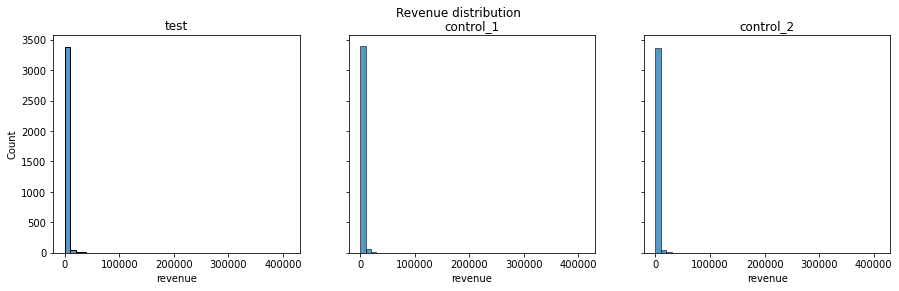

In [84]:
# посмотрим на распределения:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 4))
fig.suptitle('Revenue distribution')

# test
sns.histplot(ARPU_all_test.revenue, ax=axes[0], binwidth=10000)
axes[0].set_title('test')

# control_1
sns.histplot(ARPU_all_control_1.revenue, ax=axes[1], binwidth=10000)
axes[1].set_title('control_1')

# control_2
sns.histplot(ARPU_all_control_2.revenue, ax=axes[2], binwidth=10000)
axes[2].set_title('control_2')

По распределениям заметно, что они явно смещены влево, однако детали не видны в силу большого количества пользователей не покупавших премиум подписку. Исключим 0 значения и снова посмотрим на распределение:

Text(0.5, 1.0, 'control_2')

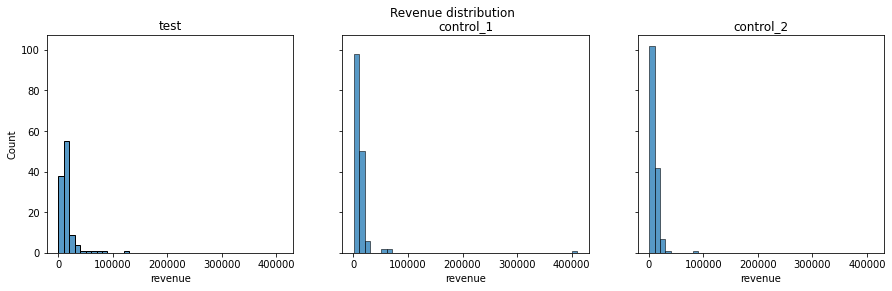

In [85]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 4))
fig.suptitle('Revenue distribution')

# test
sns.histplot(ARPU_all_test.query('revenue != 0').revenue, ax=axes[0], binwidth=10000)
axes[0].set_title('test')

# control_1
sns.histplot(ARPU_all_control_1.query('revenue != 0').revenue, ax=axes[1], binwidth=10000)
axes[1].set_title('control_1')

# control_2
sns.histplot(ARPU_all_control_2.query('revenue != 0').revenue, ax=axes[2], binwidth=10000)
axes[2].set_title('control_2')

Даже при исключении 0 заметно, что распределения выручки во всех экспериментальных группах ассиметричны, присуствуют единичные выбросы. Удалять их неверно, т.к. ARPU и ARPPU - "денежные" метрики.

Так как существует [правило](https://koch-kir.medium.com/%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F-%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D0%BC%D0%B0%D0%BD%D0%B0-%D0%B8%D0%BB%D0%B8-%D1%82%D1%80%D0%B5%D0%B1%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8E-%D0%B2-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%85-55139a5558d), если распределение удовлетворяет условиям наиболее строгих параметрических тестов , то лучше использовать именно их. 

Проверим, можно ли применять t-test к данному набору данных. Если, нормальность распределения в случае наших данных не критична, так как выборка достаточно большая, то гомогенность дисперсий стоит проверить. Для этого воспользуемся **критерием Левена**:

**Н<sub>0</sub>** - Дисперсия выручки во всех экспериментальных группах одинакова;

**Н<sub>1</sub>** - Дисперсия выручки вэкспериментальных группах отличается

И зададимся необходимым пороговым уровнем значимости  𝛼=0.05

In [86]:
# проверим гомогенность дисперсий на выручке всех пользователей
stat_all_0, p_all_0 = stats.levene(ARPU_all_test.revenue, 
                                   ARPU_all_control_1.revenue, 
                                   ARPU_all_control_2.revenue)
p_all_0

0.34929770339942295

In [87]:
# проверим гомогенность дисперсий на выручке платящих пользователей
stat_all_paid, p_all_paid = stats.levene(ARPU_all_test.query('revenue != 0').revenue, 
                                         ARPU_all_control_1.query('revenue != 0').revenue, 
                                         ARPU_all_control_2.query('revenue != 0').revenue)
p_all_paid

0.3510280204610058

p-value при проверке гомогенности дисперсий в выборках без исключения неплатящих пользователей и с исключением значимо больше 𝛼, следовательно у нас нет оснований отвергнуть нулевую гипотезу. Принимаем ее.

Вроде как условие к гомогенности дисперсии выполнено, можно применять t-test. Это понятный и более логичный выбор. Но мне больше нравится линейная регрессия, так как позволяет убить двух зайцев: и стат.вывод сделать и эффект оценить. Для общей группы **проведем оба теста**. Заодно проверим линейную регрессию на гомоскедастичность и нормальность распределения остатков. Это позволит оценить, возможно ли применение линейной регрессии с dummy-переменными к данному набору данных.

**Подводя итог:**

- конверсию в покупку премиум-подписки для тестовой и контрольных групп будем проверять с помощью критерия $\chi^2$
- влияние повышения цены на ARPU и ARPPU будем оценивать с помощью т-теста и линейной регрессии (вторую нужно проверить на гомоскедастичность и нормальность распределения остатков, чтобы оценить адекватность метода)

## 3.5 Критерий $\chi^2$<a name="chi2"></a>

In [88]:
# Создадим DF для статистического анализа через Хи-квадрат
# в связи с декартовым произведением при JOIN считаем только уникальных
test_pages = test_merged \
    .groupby('product_type', as_index=False) \
    .agg({'uid': 'nunique'}) \
    .rename(columns={'uid': 'test_count'})
control_1_pages = control_1_merged \
    .groupby('product_type', as_index=False) \
    .agg({'uid': 'nunique'}) \
    .rename(columns={'uid': 'control_1_count'})
control_2_pages = control_2_merged \
    .groupby('product_type', as_index=False) \
    .agg({'uid': 'nunique'}) \
    .rename(columns={'uid': 'control_2_count'})
for_chi = test_pages.merge(control_1_pages, how='outer', on='product_type') \
    .merge(control_2_pages, how='outer', on='product_type') 
for_chi

,product_type,test_count,control_1_count,control_2_count
0,coins,34,44,48
1,free_premium,205,205,185
2,no_product,3138,3111,3076
3,other_type,14,21,24
4,premium_no_trial,53,79,78
5,product_without_premium,5,12,12
6,trial_premium,46,57,44


### 3.5.1  А/А-тест<a name="chi2_AA"></a>
Перед проведением А/А-теста сформулируем гипотезы:

**Н<sub>0</sub>** - Распределение пользователей по типам продукта идентично в двух контрольных группах (control_1 и control_2);

**Н<sub>1</sub>** - Распределение пользователей по типам продукта в двух контрольных группах (control_1 и control_2) отличается

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [89]:
aa_test = stats.chi2_contingency(for_chi[['control_1_count', 'control_2_count']])
Pvalue_aa = aa_test[1]
Pvalue_aa

0.8421356432782787

Полученный уровень значимости **больше** порогового, следовательно нет достаточно оснований, чтобы отклонить нулевую гипотезу и поэтому ее стоит принять.

Таким образом, в результате А/А-теста мы удостоверелись, что система для проведения А/В-тестов работает корректно.

### 3.5.2 А/В-тест<a name="chi2_AB"></a>

Перед проведением А/В-теста сформулируем гипотезы:

**Н<sub>0</sub>** - Распределение пользователей по типам продукта идентично в тестовой и контрольных группах;

**Н<sub>1</sub>** - Распределение пользователей по типам продукта в тестовой и контрольных группах отличается

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

Для надежности проводить А/В-тест будем на обеих контрольных группах

In [242]:
# Первый А/В-тест
ab_test_1 = stats.chi2_contingency(for_chi[['test_count', 'control_1_count']])
Pvalue_ab_1 = ab_test_1[1]
Pvalue_ab_1

0.06627934899168832

In [243]:
# Второй А/В-тест
ab_test_2 = stats.chi2_contingency(for_chi[['test_count', 'control_2_count']])
Pvalue_ab_2 = ab_test_2[1]
Pvalue_ab_2

0.02694977231951514

Как видно в одном случае p-value > $\alpha$ (при сравнении с test и control_1), а в другом p-value < $\alpha$ (при сравнении с test и control_2), следовательно есть некоторые сомнения в том, получены ли статистически значимые различия между тестовой и контрольными группами. Смело отвергнуть нулевую гипотезу и принять альтернативную не получается.  

Посмотрим, удасться ли получить статистически значимые различия между тестовой и контрольной группами, если провести серию  А/В-тестов по конкретным группам продуктов:

для более наглядной оценки результатов введем параметр **confidence**:

- равен **0**  в случае, если при сравнении тестовой группы _ни с одной_ из контрольных не получено статистически значимых различий;
- равен **0.5** в случае, если при сравнении тестовой группы с контрольными, *на одной* группе получены статистически значимые различия
- равен **1** в случае, если при сравнении тестовой группы с контрольными, для *обоих* групп получены статистически значимые различия 

На такую проверку меня натолкнул вот этот [сайт-калькулятор AB-тестов](https://abtestguide.com/calc/?ua=4339&ub=4308&ca=106&cb=76&tail=2)

In [244]:
alpha = 0.05

# общее число юзеров в группе
all_users = {'test': test_merged.uid.nunique(), 
             'control_1': control_1_merged.uid.nunique(), 
             'control_2': control_2_merged.uid.nunique()}

# DF для сбора результатов
results_product_type_ab = pd.DataFrame(columns=['product_type', 
                                                'confidence', 
                                                'p_value_control_1', 
                                                'p_value_control_2'])
# итератор по строкам/продуктам DF for_chi
for i in range(len(for_chi)):
    product_type = for_chi.loc[i, 'product_type']
#     создаем DF для анализа
# не забываем вычесть анализируемую группу
    DF_chi_1 = pd.DataFrame([[for_chi.loc[i, 'test_count'], 
                              for_chi.loc[i, 'control_1_count']], 
                             [(all_users['test'] - for_chi.loc[i, 'test_count']),
                              (all_users['control_1'] - for_chi.loc[i, 'control_1_count'])]])
    DF_chi_2 = pd.DataFrame([[for_chi.loc[i, 'test_count'], 
                              for_chi.loc[i, 'control_2_count']], 
                             [(all_users['test'] - for_chi.loc[i, 'test_count']), 
                              (all_users['control_2'] - for_chi.loc[i, 'control_2_count'])]])
#     анализ
    ab_1 = stats.chi2_contingency(DF_chi_1)
    ab_2 = stats.chi2_contingency(DF_chi_2)
    if ab_1[1] < alpha and ab_2[1] < alpha:
        confidence = 1
    elif ab_1[1] < alpha or ab_2[1] < alpha:
        confidence = 0.5
    else:
        confidence = 0
    DF_temp = pd.DataFrame([[product_type, 
                             confidence, 
                             ab_1[1], 
                             ab_2[1]]], columns=['product_type', 
                                                 'confidence', 
                                                 'p_value_control_1', 
                                                 'p_value_control_2'])
    results_product_type_ab = results_product_type_ab.append(DF_temp)

results_product_type_ab

,product_type,confidence,p_value_control_1,p_value_control_2
0,coins,0,0.317696,0.133962
0,free_premium,0,0.992555,0.384694
0,no_product,0,0.075571,0.325979
0,other_type,0,0.317483,0.133363
0,premium_no_trial,1,0.030501,0.028802
0,product_without_premium,0,0.148431,0.138424
0,trial_premium,0,0.335433,0.960834


Как видно из представленной таблицы можно быть уверенным в том, что повышение стоимости премиум-подписки статистически значимо повлияло только на количество покупателей премиум подписки.

In [245]:
# В качестве контроля проведем аналогичную операцию для двух контрольных групп

# DF для сбора результатов
results_product_type_aa = pd.DataFrame(columns=['product_type', 
                                                'confidence', 
                                                'p_value'])
# итератор по строкам DF for_chi
for i in range(len(for_chi)):
    product_type = for_chi.loc[i, 'product_type']
#     создаем DF для анализа
    DF_chi_aa = pd.DataFrame([[for_chi.loc[i, 'control_1_count'], 
                               for_chi.loc[i, 'control_2_count']], 
                              [(all_users['control_1'] - for_chi.loc[i, 'control_1_count']), 
                               (all_users['control_2'] - for_chi.loc[i, 'control_2_count'])]])
    
#     анализ
    aa = stats.chi2_contingency(DF_chi_aa)
    if aa[1] < alpha:
        confidence = 1
    else:
        confidence = 0
    DF_temp = pd.DataFrame([[product_type, confidence, aa[1]]], 
                           columns=['product_type',
                                    'confidence',
                                    'p_value'])
    results_product_type_aa = results_product_type_aa.append(DF_temp)

results_product_type_aa

,product_type,confidence,p_value
0,coins,0,0.688861
0,free_premium,0,0.417627
0,no_product,0,0.454384
0,other_type,0,0.719798
0,premium_no_trial,0,1.000000
0,product_without_premium,0,1.000000
0,trial_premium,0,0.265584


Данная таблица помимо проверки кода дополнительно подтверждает гипотезу сформулированную выше: распределение пользователей по двум контрольным группам идентично

### 3.5.3 Выводы<a name="chi2_conclusions"></a>
1) В результате А/А-теста не удалось обнаружить статистически значимых различий по распределению пользователей по product_type для двух контрольных групп. Это означает, что система для проведения А/В-тестов работает корректно и результатам A/B-тестов можно доверять.

2) Общий А/В-тест, сравниваающий распределения пользователей по всем группам товаров дал спорный результат: при сравнении тестовой группы с одной контрольной группой результат оказался стат. значимым, при сравнении с другой - нет. Однако удалось обнаружить статистически значимые различия в распределении пользователей между контрольной и тестовой группой по продукту premium_no_trial  

3) К сожалению, использование критерия $\chi^2$ дает только качественный ответ на вопрос отличается ли тестовая группа от контрольной. 


## 3.6 T-тест для статистической оценки влияния теста на ARPU и ARPPU<a name="ttest"></a>

### 3.6.1 А/А-тест <a name="aa-ttest"></a>
Оценим влияние системы сплитоваания на ARPU и ARPPU:

Перед проведением А/A-теста сформулируем гипотезы:

**Н<sub>0</sub>** - ARPU/ARPPU в обеих контрольных группах одинаково и система сплитования работает корректно;

**Н<sub>1</sub>** - ARPU/ARPPU в контрольных группах отличается, система сплитования сломана

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [246]:
# А/А-тест ARPU
stats.ttest_ind(ARPU_all_control_1.revenue, ARPU_all_control_2.revenue).pvalue

0.1808793318477501

In [247]:
# А/А-тест ARPPU
stats.ttest_ind(ARPU_all_control_1.query('revenue != 0').revenue, 
                ARPU_all_control_2.query('revenue != 0').revenue).pvalue

0.16484407249820576

Значения p-value > $\alpha = 0.05$ как для ARPU, так и для ARPPU. Оснований отклонить Н<sub>0</sub> нет, принимаем нулевую гипотезу

### 3.6.2 А/В-тест <a name="ab-ttest"></a>

Перед проведением А/B-теста сформулируем гипотезы:

**Н<sub>0</sub>** - ARPU/ARPPU в контрольной и тестовой группах одинаковы, повышение цены премиум-подписки НЕ привело к изменению  ARPU/ARPPU;

**Н<sub>1</sub>** - ARPU/ARPPU в контрольной и тестовой группах отличается, повышение цены премиум-подписки привело к изменению  ARPU/ARPPU

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [248]:
# А/B-тест ARPU (с первой контрольной группой)
stats.ttest_ind(ARPU_all_test.revenue, ARPU_all_control_1.revenue).pvalue

0.5648731874055088

In [249]:
# А/B-тест ARPU (с второй контрольной группой)
stats.ttest_ind(ARPU_all_test.revenue, ARPU_all_control_2.revenue).pvalue

0.2504244381860756

In [250]:
# А/B-тест ARPPU (с первой контрольной группой)
stats.ttest_ind(ARPU_all_test.query('revenue != 0').revenue, 
                ARPU_all_control_1.query('revenue != 0').revenue).pvalue

0.38086932427899844

In [251]:
# А/B-тест ARPPU (с второй контрольной группой)
stats.ttest_ind(ARPU_all_test.query('revenue != 0').revenue, 
                ARPU_all_control_2.query('revenue != 0').revenue).pvalue

2.7613620651702702e-05

Как видно из результатов Т-теста по метрике ARPU оба p-value больше порогового значения, а значит мы принимаем нулевую гипотезу об отсутсвии статистически значимых различий в показателе ARPU для тестовой и обеих контрольных группах.

При оценке влияния условий теста на показатель ARPPU получились противоречивые результаты. Одно p-value (между test и control_1) > $\alpha$, другое p-value (между test и control_2) < $\alpha$

Похожая ситуация наблюдалась также для конверсии оцененной с помощью критерия $\chi^2$
В той ситуации выяснилось, что стат.значимые различия наблюдаются только в отношении покупателей подприски premium_no_trial

Оценим изменения ARPU и ARPPU в отношении этой категории товаров:

In [252]:
# Создание DF для анализа
# суммируем только покупки premium_no_trial
ARPU_test = test_merged \
    .groupby('uid') \
    .apply(lambda x: x[x['product_type'] == 'premium_no_trial']['revenue'].sum()) \
    .to_frame() \
    .reset_index() \
    .rename(columns={0: 'revenue'})
ARPU_test['group'] = 'test'

ARPU_control_1 = control_1_merged \
    .groupby('uid') \
    .apply(lambda x: x[x['product_type'] == 'premium_no_trial']['revenue'].sum()) \
    .to_frame() \
    .reset_index() \
    .rename(columns={0: 'revenue'})
ARPU_control_1['group'] = 'control'

ARPU_control_2 = control_2_merged \
    .groupby('uid') \
    .apply(lambda x: x[x['product_type'] == 'premium_no_trial']['revenue'].sum()) \
    .to_frame() \
    .reset_index() \
    .rename(columns={0: 'revenue'})
ARPU_control_2['group'] = 'control'

# проверка кол-ва строк в DF
print(f'Количество строк в разных экспериментальных группах: \ntest: {ARPU_test.shape[0]}')
print(f'control_1: {ARPU_control_1.shape[0]}\ncontrol_2: {ARPU_control_2.shape[0]}')

Количество строк в разных экспериментальных группах: 
test: 3455
control_1: 3475
control_2: 3414


Сформулируем гипотезы:

**Н<sub>0</sub>** - ARPU/ARPPU **покупок премиум подписки** в контрольной и тестовой группах одинаковы, повышение цены премиум-подписки НЕ привело к изменению  ARPU/ARPPU;

**Н<sub>1</sub>** - ARPU/ARPPU **покупок премиум подписки** в контрольной и тестовой группах отличается, повышение цены премиум-подписки привело к изменению  ARPU/ARPPU

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [253]:
# А/B-тест ARPU (с первой контрольной группой)
stats.ttest_ind(ARPU_test.revenue, ARPU_control_1.revenue).pvalue

0.997940709101055

In [254]:
# А/B-тест ARPU (с второй контрольной группой)
stats.ttest_ind(ARPU_test.revenue, ARPU_control_2.revenue).pvalue

0.7436561439400442

In [255]:
# А/B-тест ARPPU (с первой контрольной группой)
stats.ttest_ind(ARPU_test.query('revenue != 0').revenue, 
                ARPU_control_1.query('revenue != 0').revenue).pvalue

0.09051664790615033

In [256]:
# А/B-тест ARPPU (с второй контрольной группой)
stats.ttest_ind(ARPU_test.query('revenue != 0').revenue, 
                ARPU_control_2.query('revenue != 0').revenue).pvalue

0.03217527916337261

Как видно из результатов Т-теста по метрике ARPU оба p-value больше порогового значения, а значит мы принимаем нулевую гипотезу об отсутсвии статистически значимых различий в показателе ARPU для тестовой и обеих контрольных группах. Причем отмечу, что эти значения p-value выше, чем для Т-теста проведенного без фильтрации по типу продукта (product_type == premium_no_trial)

При оценке влияния условий теста на показатель ARPPU также получились противоречивые результаты. Одно p-value (между test и control_1) > $\alpha$, другое p-value (между test и control_2) < $\alpha$. Однако отмечу, что p-value, которое больше порога выше его не намного. 

Поэтому можно **осторожно** предположить, что при повышении стоимости премиум подписки ARPPU увеличивается (см. табл. ниже) в то время как ARPU не меняется и, следовательно, рост стоимости подписки компенсируется уменьшением конверсии пользователей в покупку премиум-подписки.

In [257]:
# ARPU и ARPPU фильтрованных данных (product_type == premium_no_trial) 
pd.DataFrame([[ARPU_test.revenue.mean(),
               ARPU_control_1.revenue.mean(),
               ARPU_control_2.revenue.mean()],
              [ARPU_test.query('revenue != 0').revenue.mean(),
               ARPU_control_1.query('revenue != 0').revenue.mean(),
               ARPU_control_2.query('revenue != 0').revenue.mean()]], 
             columns=['test', 'control_1', 'control_2'], 
             index=['ARPU', 'ARPPU'])

,test,control_1,control_2
ARPU,176.611867,176.743885,160.641769
ARPPU,11513.094340,7774.493671,7031.166667


## 3.7 Линейная регрессия для оценки влияния категориального фактора на ARPU и ARPPU<a name="line_regress"></a>

Этот метод позволит оценить влияние категориального фактора (принадлежность к тестовой или контрольной группе) на количественную метрику например таких как ARPU и ARPPU.

### 3.7.1 Влияние повышения стоимости премиум-подписки на ARPU премиум-подписки<a name="line_regress_ARPU"></a>

Сформулируем гипотезы:

**Н<sub>0</sub>** - ARPU не зависит от повышения цены на premium подписку или другими словами ARPU тестовой и контрольной группы равны;

**Н<sub>1</sub>** - ARPU зависит от повышения цены на premium подписку или другими словами ARPU тестовой и контрольной группы отличаются

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [258]:
# сделаем DF для регрессии
# присвоим группам соответствующие метки
ARPU_all_test['group'] = 'test'
ARPU_all_control_1['group'] = 'control'
ARPU_all_control_2['group'] = 'control'

# объединим DF
ARPU_all_test_control_1 = ARPU_all_test.append(ARPU_all_control_1)
ARPU_all_test_control_2 = ARPU_all_test.append(ARPU_all_control_2)

# созданиие dummy-переменных в DF
ARPU_all_test_control_1 = pd.get_dummies(ARPU_all_test_control_1, drop_first=True).assign(aov=1)
ARPU_all_test_control_2 = pd.get_dummies(ARPU_all_test_control_2, drop_first=True).assign(aov=1)
ARPU_all_test_control_1.head(1)

,uid,revenue,group_test,aov
0,891051147,0.0,1,1


In [259]:
# линейная регрессия по данным ARPU_test_control_1
est_ARPU_all_test_control_1 = OLS(ARPU_all_test_control_1['revenue'], 
                                  ARPU_all_test_control_1[['group_test', 'aov']]).fit()
print(est_ARPU_all_test_control_1.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3314
Date:                Sat, 22 Apr 2023   Prob (F-statistic):              0.565
Time:                        16:37:11   Log-Likelihood:                -70219.
No. Observations:                6930   AIC:                         1.404e+05
Df Residuals:                    6928   BIC:                         1.405e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
group_test   -84.1707    146.220     -0.576      0.5

Проверим регрессию на гомоскедастичность с помощью теста [Breusch-Pagan](https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab):

Сформулируем гипотезу:

**Н<sub>0</sub>** - Гомоскедастичность остатков линейной регрессии наблюдается;

**Н<sub>1</sub>** - У данной линейной регрессии наблюдается гетероскедастичность остатков

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [260]:
test_result = het_breuschpagan(est_ARPU_all_test_control_1.resid, est_ARPU_all_test_control_1.model.exog)

names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
 
print(dict(zip(names, test_result)))

{'Lagrange multiplier statistic': 0.6653649394493799, 'p-value': 0.41467228275888224, 'f-value': 0.6652367858206635, 'f p-value': 0.41474526531895406}


Так как p-value при проведении теста Breusch-Pagan больше порогового значения, мы принимаем нудевую гипотезу.
Таким образом, у данной линейной регрессии выполняется требование к гомоскедастичности остатков.

Также проверим линейную регрессию на требование нормальности распределения остатков с помощью теста [**Jarque-Bera**](https://www.statsmodels.org/dev/diagnostic.html):


**Н<sub>0</sub>** - Наблюдается нормальное распределение остатков;

**Н<sub>1</sub>** - Наблюдается асимметрия и эксцесс распределения остатков, которые значительно отличаются от нормального распределения.

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [261]:
stats.jarque_bera(est_ARPU_all_test_control_1.resid)

Jarque_beraResult(statistic=2270799540.947476, pvalue=0.0)

Как видно из результатов теста Jarque-Bera p-value < $\alpha$, и, следовательно, у нас есть статистически значимые основания принять первую гипотезу о том, что распределение остатков в регрессии отклоняются от нормальности.

### 3.7.2 Вывод:<a name="line_regress_conclusions"></a>

Таким образом, можно сделать вывод, что линейная регрессия **не подходит** для статистического анализа ARPU и ARPPU

## 3.8 Выводы А/А/B - теста<a name="AAB_conclusions"></a>

1) Система сплитования работает корректно как при оценке распределения пользователей по product_type так по ARPU и ARPPU

2) В результате проведения теста тестовая группа относительно контрольных показала статистически значимый результат по метрике количество покупок премиум подписки, количество пользователей оформивших подписку уменьшилось на 32 - 33%

3) В процессе теста НЕудалось получить статистически значимых различий по ARPU. Относительное повышение цены на премиум подписку нивелируется снижением конверсии в покупку подписки. Однако можно **осторожно** признать что ARPPU для тех кто оформил премиум подписку выросло, что в целом логично.

**Вывод:** считать ли эксперимент успешным в целом зависит от цели эксперимента. Если целью было увеличение ARPU, то результаты эксперимента отрицательные. Если целью было снижение издержек при сохранении ARPU, то результат можно считать успешным. Так как задание нам "намекает" на то, что результат не успешен в целом, признаем его не успешным

# 4 Поиск групп пользователей, на которых нововведение имеет смысл<a name="solving"></a>

Определим критерии, по которым мы будем считать, что для какой-то группы пользователей результат эксперимента успешен:

1) не получены статистически значимые отличия в количестве премиум-подписок в тестовой и контрольной группах для этой категории пользователей.

2) видны статистически значимые отличия в ARPU тестовой и контрольной группах

Соблюдение этих двух критериев одновременно - идеальный вариант для рекомендации сегмента к применению новвоведения. Соблюдение как минимум одного - неплохо. Возможно для получения значимых отличий в ARPU потребуется больший размер выборки т.к. дисперсия по выручке у пользователей очень большая.

Искать будем только в с фильтрациаей по покупке премиум-подписки, там изменения будут наиболее явные и соответственно обнаружит их будет легче.

Как можно сегментировать пользователей:
- пол
- возраст (разбить на категории: до 25), \[25-35\), \[35-45\), после 45)
- страны

Количество дней посещений, attraction_coeff, views_count, мне кажется, не могут быть использованы как критерии для сегментации так как эти данные появляются после регистрации и спользования приложения. Пользователей будет очень злить тот факт, что мы по истечении какого-то скрока их запишем их сегмент тех кто купит подписку и на 30% дороже

In [262]:
# Подготовка DF для анализа

# тестовая группа
test_segmentation = test_merged.copy()
test_segmentation['count_premium_no_trial'] = np.where(test_segmentation.product_type == 'premium_no_trial', 1, 0)
# убираем дубли uid, join выручку и кол-во premium_no_trial
test_segmentation = test_segmentation \
    .groupby(['uid', 'age', 'gender', 'country_x', 'was_premium'], as_index=False) \
    .agg({'count_premium_no_trial': 'sum'}) \
    .assign(aov=1) \
    .merge(ARPU_test[['uid', 'revenue']], on='uid', how='inner') \
    .drop(labels='uid', axis=1)
# определяем сам факт покупки  premium_no_trial
test_segmentation['is_premium_no_trial'] = np.where(test_segmentation.count_premium_no_trial > 0, 1, 0)
    
# контрольная группа 1
control_1_segmentation = control_1_merged.copy()
control_1_segmentation['count_premium_no_trial'] = np.where(control_1_segmentation.product_type == 'premium_no_trial',
                                                            1, 0)
# убираем дубли uid, join выручку и кол-во premium_no_trial
control_1_segmentation = control_1_segmentation \
    .groupby(['uid', 'age', 'gender', 'country_x', 'was_premium'], as_index=False) \
    .agg({'count_premium_no_trial': 'sum'}) \
    .assign(aov=1) \
    .merge(ARPU_control_1[['uid', 'revenue']], on='uid', how='inner') \
    .drop(labels='uid', axis=1)
# определяем сам факт покупки  premium_no_trial
control_1_segmentation['is_premium_no_trial'] = np.where(control_1_segmentation.count_premium_no_trial > 0, 1, 0)

# контрольная группа 2
control_2_segmentation = control_2_merged.copy()
control_2_segmentation['count_premium_no_trial'] = np.where(control_2_segmentation.product_type == 'premium_no_trial', 
                                                            1, 0)
# убираем дубли uid, join выручку и кол-во premium_no_trial
control_2_segmentation = control_2_segmentation \
    .groupby(['uid', 'age', 'gender', 'country_x', 'was_premium'], as_index=False) \
    .agg({'count_premium_no_trial': 'sum'}) \
    .assign(aov=1) \
    .merge(ARPU_control_2[['uid', 'revenue']], on='uid', how='inner') \
    .drop(labels='uid', axis=1)

# определяем сам факт покупки  premium_no_trial
control_2_segmentation['is_premium_no_trial'] = np.where(control_2_segmentation.count_premium_no_trial > 0, 1, 0)

# проверка размеров DF
print(f'Количество строк в разных экспериментальных группах: \ntest: {test_segmentation.shape[0]}')
print(f'control_1: {control_1_segmentation.shape[0]}\ncontrol_2: {control_2_segmentation.shape[0]}')

Количество строк в разных экспериментальных группах: 
test: 3455
control_1: 3475
control_2: 3414


Во всех DF количество строк сошлось с количеством пользователей в каждой экспериментальной группе.

для более наглядной оценки результатов введем параметр **confidence**:

- равен **0**  в случае, если при сравнении тестовой группы _ни с одной_ из контрольных не получено статистически значимых различий;
- равен **0.5** в случае, если при сравнении тестовой группы с контрольными, *на одной* группе получены статистически значимые различия
- равен **1** в случае, если при сравнении тестовой группы с контрольными, для *обоих* групп получены статистически значимые различия 

In [263]:
# определяем границы сегментов по возрасту
min_age = [0, 24, 34, 44] 
max_age = [25, 35, 45, 100]
# предусмотрим возникновение небинарных личностей
genders = test_merged.gender \
    .append(control_1_merged.gender) \
    .append(control_2_merged.gender) \
    .unique()
# собираем список всех стран
countries = test_merged.country_x \
    .append(control_1_merged.country_x) \
    .append(control_2_merged.country_x) \
    .unique()
# пустой DF для результатов
segmentation_results_all = pd.DataFrame(columns=['segment',         # наименование сегмента
                                                 'segment_value',   # значение сегмента
                                                 'confidence',      # коэффициент доверия результату
                                                 'metric',          # метрика
                                                 'effect',          # относительное изменение метрики
                                                 'p_value_1',       # при сравнении тестовой и control_1
                                                 'p_value_2',       # при сравнении тестовой и control_2
                                                 'sample_size_test',        # размер тестовой группы
                                                 'sample_size_control_1',   # размер группы control_1
                                                 'sample_size_control_1'])  # азмер группы control_2

Сформулируем гипотезы для статистического анализа количества пользователей купивших премиум подписку (СR) и для метрик ARPU и ARPPU:

**CR:**

**Н<sub>0</sub>** - Количество пользователей купивших премиум подписку идентично в тестовой и контрольных группах;

**Н<sub>1</sub>** - Количество пользователей купивших премиум подписку в тестовой и контрольных группах отличается

**ARPU и ARPPU:**

**Н<sub>0</sub>** - ARPU/ARPPU покупок премиум подписки в контрольной и тестовой группах одинаковы, повышение цены премиум-подписки НЕ привело к изменению ARPU/ARPPU;

**Н<sub>1</sub>** - ARPU/ARPPU покупок премиум подписки в контрольной и тестовой группах отличается, повышение цены премиум-подписки привело к изменению ARPU/ARPPU

И зададимся необходимым пороговым уровнем значимости $\alpha = 0.05$

In [264]:
# функция для статистической обработки результатов А/В-теста по сегментам
def stat_ARPU_ARPPU_CR(DF_test, DF_control_1, DF_control_2, segment, segment_value):
    """
    Функция проводит А/В-тесты и 
    рассчитывает p-value для количества покупателей премиум подписки c использованием Chi^2, 
    а также для ARPU и ARPPU с использованием Т-теста, сравнивая тестовую группу с обеими контрольными. 
    Критерий Chi^2 рассчитывается если число измерений в каждой ячейке >= 5
    Т-тест проводится, если число наблюдений больше 30 (для того чтобы не было требования к нормальности распределения)
    Если по выборка не удовлетворяет описанным выше критериям p-value = NaN.
    Если при сравнении какое либо значение p-value меньше установленного порога alpha, 
    то рассчитаывается эффект воздействия
    Также функция считает размеры выборок.
    
    """
    
    sample_size_test_ARPU_CR = len(DF_test)
    sample_size_control_1_ARPU_CR = len(DF_control_1)
    sample_size_control_2_ARPU_CR = len(DF_control_2)
    
    sample_size_test_ARPPU = len(DF_test.query('revenue != 0'))
    sample_size_control_1_ARPPU = len(DF_control_1.query('revenue != 0'))
    sample_size_control_2_ARPPU = len(DF_control_2.query('revenue != 0'))
       
    # ARPU
    metric_ARPU = 'ARPU'
    confidence_ARPU = 0
    
    # значения коэффициентов по умолчанию
    effect_ARPU = '-'
    p_value_ARPU_1, p_value_ARPU_2 = math.nan, math.nan
    
    # отбор по минимальному значению размера выборки
    if ((sample_size_test_ARPU_CR > 30) 
       and (sample_size_control_1_ARPU_CR > 30)  
       and (sample_size_control_2_ARPU_CR > 30)):
    
        # T-test test_control_1
        p_value_ARPU_1 = stats.ttest_ind(DF_test.revenue, DF_control_1.revenue).pvalue
        # T-test test_control_2
        p_value_ARPU_2 = stats.ttest_ind(DF_test.revenue, DF_control_2.revenue).pvalue


        # если результат стат.значим:
        if (p_value_ARPU_1 < alpha) and (p_value_ARPU_2 < alpha):

            confidence_ARPU = 1

            ARPU_test = DF_test.revenue.mean()
            ARPU_control_1 = DF_control_1.revenue.mean()
            ARPU_control_2 = DF_control_2.revenue.mean()

            # оценка эффекта воздействия
            effect_1_ARPU = ((ARPU_test - ARPU_control_1) / ARPU_control_1 * 100).round(1)
            effect_2_ARPU = ((ARPU_test - ARPU_control_2) / ARPU_control_2 * 100).round(1)
            effect_ARPU = f'{min(effect_1_ARPU, effect_2_ARPU)} - {max(effect_1_ARPU, effect_2_ARPU)} %'
            # если результат частично стат.значим
        elif (p_value_ARPU_1 < alpha) or (p_value_ARPU_2 < alpha):
            confidence_ARPU = 0.5
            # оценка эффекта воздействия
            if p_value_ARPU_1 < alpha:
                ARPU_test = DF_test.revenue.mean()
                ARPU_control_1 = DF_control_1.revenue.mean()
                effect_ARPU = str(((ARPU_test - ARPU_control_1) / ARPU_control_1 * 100).round(1)) + '%'
            else:
                ARPU_test = DF_test.revenue.mean()
                ARPU_control_2 = DF_control_2.revenue.mean()
                effect_ARPU = str(((ARPU_test - ARPU_control_2) / ARPU_control_2 * 100).round(1)) + '%'
            
    # ARPPU
    
    metric_ARPPU = 'ARPPU'
    confidence_ARPPU = 0
    
    # значения коэффициентов по умолчанию
    effect_ARPPU = '-'
    p_value_ARPPU_1, p_value_ARPPU_2 = math.nan, math.nan
    
    # фильтруем DF для расчета ARPPU
    DF_test_ARPPU = DF_test.query('revenue != 0')
    DF_control_1_ARPPU = DF_control_1.query('revenue != 0')
    DF_control_2_ARPPU = DF_control_2.query('revenue != 0')
    
    # отбор по минимальному значению размера выборки
    if ((sample_size_test_ARPPU > 30) 
       and (sample_size_control_1_ARPPU > 30)  
       and (sample_size_control_2_ARPPU > 30)):
    
        # T-test test_control_1 
        p_value_ARPPU_1 = stats.ttest_ind(DF_test_ARPPU.revenue, DF_control_1_ARPPU.revenue).pvalue
        # T-test test_control_2  
        p_value_ARPPU_2 = stats.ttest_ind(DF_test_ARPPU.revenue, DF_control_2_ARPPU.revenue).pvalue


        # если результат стат.значим:
        if (p_value_ARPPU_1 < alpha) and (p_value_ARPPU_2 < alpha):

            confidence_ARPPU = 1

            ARPPU_test = DF_test_ARPPU.revenue.mean()
            ARPPU_control_1 = DF_control_1_ARPPU.revenue.mean()
            ARPPU_control_2 = DF_control_2_ARPPU.revenue.mean()

            # оценка эффекта воздействия
            effect_1_ARPPU = ((ARPPU_test - ARPPU_control_1) / ARPPU_control_1 * 100).round(1)
            effect_2_ARPPU = ((ARPPU_test - ARPPU_control_2) / ARPPU_control_2 * 100).round(1)
            effect_ARPPU = f'{min(effect_1_ARPPU, effect_2_ARPPU)} - {max(effect_1_ARPPU, effect_2_ARPPU)} %'
            # если результат частично стат.значим
        elif (p_value_ARPPU_1 < alpha) or (p_value_ARPPU_2 < alpha):
            confidence_ARPPU = 0.5
            # оценка эффекта воздействия
            if p_value_ARPPU_1 < alpha:
                ARPPU_test = DF_test_ARPPU.revenue.mean()
                ARPPU_control_1 = DF_control_1_ARPPU.revenue.mean()
                effect_ARPPU = str(((ARPPU_test - ARPPU_control_1) / ARPPU_control_1 * 100).round(1)) + '%'
            else:
                ARPPU_test = DF_test_ARPPU.revenue.mean()
                ARPPU_control_2 = DF_control_2_ARPPU.revenue.mean()
                effect_ARPPU = str(((ARPPU_test - ARPPU_control_2) / ARPPU_control_2 * 100).round(1)) + '%'

    # CR
    
    metric_CR = 'CR'
    confidence_CR = 0
    
    # значения коэффициентов по умолчанию
    effect_CR = '-'
    p_value_CR_1, p_value_CR_2 = math.nan, math.nan
    
    # отбор по минимальному значению частот
    if ((DF_test.is_premium_no_trial.sum() >= 5) 
        and (DF_control_1.is_premium_no_trial.sum() >= 5) 
        and ((DF_test.shape[0] - DF_test.is_premium_no_trial.sum()) >= 5) 
        and ((DF_control_1.shape[0] - DF_control_1.is_premium_no_trial.sum()) >= 5)):
    
        # Chi^2 test_control_1
        # не забываем вычесть анализируемую группу
        DF_chi_1 = pd.DataFrame([[DF_test.is_premium_no_trial.sum(), 
                                  DF_control_1.is_premium_no_trial.sum()], 
                                 [(DF_test.shape[0] - DF_test.is_premium_no_trial.sum()),
                                  (DF_control_1.shape[0] - DF_control_1.is_premium_no_trial.sum())]])    
        p_value_CR_1 = stats.chi2_contingency(DF_chi_1)[1]

        # Chi^2 test_control_2
        DF_chi_2 = pd.DataFrame([[DF_test.is_premium_no_trial.sum(), 
                                  DF_control_2.is_premium_no_trial.sum()], 
                                 [(DF_test.shape[0] - DF_test.is_premium_no_trial.sum()),
                                  (DF_control_2.shape[0] - DF_control_2.is_premium_no_trial.sum())]])    
        p_value_CR_2 = stats.chi2_contingency(DF_chi_2)[1]

        # если результат стат.значим:
        if (p_value_CR_1 < alpha) and (p_value_CR_2 < alpha):

            confidence_CR = 1

            # оценка эффекта воздействия
            effect_1_CR = ((DF_test.is_premium_no_trial.sum() - DF_control_1.is_premium_no_trial.sum()) 
                           / DF_control_1.is_premium_no_trial.sum() * 100).round(1)
            effect_2_CR = ((DF_test.is_premium_no_trial.sum() - DF_control_2.is_premium_no_trial.sum()) 
                           / DF_control_2.is_premium_no_trial.sum() * 100).round(1)
            effect_CR = f'{min(effect_1_CR, effect_2_CR)} - {max(effect_1_CR, effect_2_CR)} %'

        elif (p_value_CR_1 < alpha) or (p_value_CR_2 < alpha):
            confidence_CR = 0.5
            # оценка эффекта воздействия
            if p_value_CR_1 < alpha:
                effect_CR = str(((DF_test.is_premium_no_trial.sum() - DF_control_1.is_premium_no_trial.sum()) 
                                 / DF_control_1.is_premium_no_trial.sum() * 100).round(1)) + '%'
            else:
                effect_CR = str(((DF_test.is_premium_no_trial.sum() - DF_control_2.is_premium_no_trial.sum()) 
                                 / DF_control_2.is_premium_no_trial.sum() * 100).round(1)) + '%'
    
    DF_temp = pd.DataFrame([[segment, 
                             segment_value, 
                             confidence_ARPU, 
                             metric_ARPU,
                             effect_ARPU,
                             p_value_ARPU_1,
                             p_value_ARPU_2,
                             sample_size_test_ARPU_CR,
                             sample_size_control_1_ARPU_CR,
                             sample_size_control_2_ARPU_CR],
                            [segment, 
                             segment_value, 
                             confidence_ARPPU, 
                             metric_ARPPU,
                             effect_ARPPU,
                             p_value_ARPPU_1,
                             p_value_ARPPU_2,
                             sample_size_test_ARPPU,
                             sample_size_control_1_ARPPU,
                             sample_size_control_2_ARPPU],
                            [segment, 
                             segment_value, 
                             confidence_CR, 
                             metric_CR,
                             effect_CR,
                             p_value_CR_1,
                             p_value_CR_2,
                             sample_size_test_ARPU_CR,
                             sample_size_control_1_ARPU_CR,
                             sample_size_control_2_ARPU_CR]], 
                           columns=['segment',         # наименование сегмента
                                    'segment_value',   # значение сегмента
                                    'confidence',      # коэффициент доверия результату
                                    'metric',          # метрика
                                    'effect',          # относительное изменение метрики
                                    'p_value_1',       # при сравнении тестовой и control_1
                                    'p_value_2',       # при сравнении тестовой и control_2
                                    'sample_size_test',        # размер тестовой группы
                                    'sample_size_control_1',   # размер группы control_1
                                    'sample_size_control_1'])  # азмер группы control_2
   
    return DF_temp    

In [265]:
# итерация по возрастным группам
for i in range(len(min_age)):
    segment = 'age'
    segment_value = '[' + str(min_age[i] + 1) + '-' + str(max_age[i]) + ')'
    max_age_i = max_age[i]
    min_age_i = min_age[i]
    
#     получение фильтрованных DF
    filtered_DF_test = test_segmentation.query('age > @min_age_i and age < @max_age_i')

    filtered_DF_control_1 = control_1_segmentation.query('age > @min_age_i and age < @max_age_i') 
    
    filtered_DF_control_2 = control_2_segmentation.query('age > @min_age_i and age < @max_age_i') 
    
    # применение функции объявленной выше
    results = stat_ARPU_ARPPU_CR(filtered_DF_test, 
                                 filtered_DF_control_1, 
                                 filtered_DF_control_2, 
                                 segment, 
                                 segment_value)
    # запись в DF с результатами
    segmentation_results_all = segmentation_results_all.append(results)
   

#  # итерация по полу
for i in genders:
    segment = 'gender'
    segment_value = i
    # получение фильтрованных DF
    filtered_DF_test = test_segmentation.query('gender == @segment_value')
    filtered_DF_control_1 = control_1_segmentation.query('gender == @segment_value')
    filtered_DF_control_2 = control_2_segmentation.query('gender == @segment_value')
    # применение функции объявленной выше
    results = stat_ARPU_ARPPU_CR(filtered_DF_test, 
                                 filtered_DF_control_1, 
                                 filtered_DF_control_2, 
                                 segment, 
                                 segment_value)
    # запись в DF с результатами
    segmentation_results_all = segmentation_results_all.append(results)
    
# Итерация по стране
for i in countries:
    segment = 'country'
    segment_value = i
    # получение фильтрованных DF
    filtered_DF_test = test_segmentation.query('country_x == @segment_value')
    filtered_DF_control_1 = control_1_segmentation.query('country_x == @segment_value')
    filtered_DF_control_2 = control_2_segmentation.query('country_x == @segment_value')
    
    # применение функции объявленной выше
    results = stat_ARPU_ARPPU_CR(filtered_DF_test, 
                                 filtered_DF_control_1, 
                                 filtered_DF_control_2, 
                                 segment, 
                                 segment_value)
    # запись в DF с результатами
    segmentation_results_all = segmentation_results_all.append(results)
    
    
segmentation_results_all.head(1)

,segment,segment_value,confidence,metric,effect,p_value_1,p_value_2,sample_size_test,sample_size_control_1,sample_size_control_1
0,age,[1-25),0.0,ARPU,-,0.193606,0.441607,902,901,906


In [266]:
segmentation_results_all.shape

(48, 10)

### Предварительный просмотр DF с результатами статистической обработки сегментированных данных показывает:
- получилось достаточно большое кол-во сегментов - 12 (кол-во строк в DF/3, т.к. метрики 3);
- есть результаты которые показывают, что есть статистически значимые основания отклонить H<sub>0</sub>  в пользу H<sub>1</sub> 
- также есть результаты, которые не дают достаточно оснований отвергнуть H<sub>0</sub>
- минимальный размер DF, которые используются для статистического анализа отличается от максимального более чем на 3 порядка
- есть ряд сегментов, где провести статистический анализ было невозможно, в силу малой выборки, в данных строках p-value == NaN их нужно отфильтровать:

In [267]:
filtered_segm_results = \
    segmentation_results_all[segmentation_results_all['p_value_1'].notnull() 
                             & segmentation_results_all['p_value_2'].notnull()]
# отфильтроваав данные по размеру DF для регрессиии количество рассматриваемых сегментов сузилось до:
filtered_segm_results.shape[0] / 3

8.0

In [268]:
filtered_segm_results.tail(5)

,segment,segment_value,confidence,metric,effect,p_value_1,p_value_2,sample_size_test,sample_size_control_1,sample_size_control_1
2,country,Argentina,0.0,CR,-,1.000000,0.774508,396,389,397
0,country,Belgium,0.0,ARPU,-,0.403672,0.299654,92,108,90
0,country,Chile,0.0,ARPU,-,0.370528,0.600030,272,287,286
0,country,United Kingdom (Great Britain),0.0,ARPU,-,0.828378,0.208855,169,146,146
0,country,United Arab Emirates,0.0,ARPU,-,0.227584,0.695587,226,207,211


Причем для ряда сегментов с озвученными в функции критериями (для Т-теста выборка > 30, для $\chi^2$ чатота >=5) удалось посчитать не все метрики. Так как озвученные выше критерии включали требования к метрикам ARPU и количеству купивших премиум подписку (CR), для дальнейшего анализа оставим те сегменты, для которых обе эти метрики статистически оценены:

In [272]:
valid_segments = filtered_segm_results \
    .query('metric != "ARPPU"') \
    .groupby(['segment', 'segment_value'], as_index=False) \
    .agg({'metric': 'count'}) \
    .rename(columns={'metric': 'count_CR_ARPU'}) \
    .query('count_CR_ARPU == 2') \
    .segment_value \
    .to_frame()
valid_segments

,segment_value
0,[1-25)
1,[25-35)
2,[35-45)
3,[45-100)
4,Argentina
10,Italy
13,United States of America
14,1


Как видно, сегментов для анализа осталось 8. Посмотрим на DF с результатами статистического анализа, отфильтрованный по этим сегментам:

In [274]:
filtered_segm_results = filtered_segm_results \
    .merge(valid_segments, how='inner', on='segment_value')
filtered_segm_results

,segment,segment_value,confidence,metric,effect,p_value_1,p_value_2,sample_size_test,sample_size_control_1,sample_size_control_1
0,age,[1-25),0.0,ARPU,-,0.193606,0.441607,902,901,906
1,age,[1-25),0.5,CR,-48.3%,0.249664,0.048923,902,901,906
2,age,[25-35),0.0,ARPU,-,0.467611,0.948432,1394,1351,1393
3,age,[25-35),0.5,CR,-48.6%,0.065671,0.026310,1394,1351,1393
4,age,[35-45),0.0,ARPU,-,0.460382,0.164227,750,780,683
5,age,[35-45),0.0,CR,-,1.000000,0.300047,750,780,683
6,age,[45-100),0.0,ARPU,-,0.530855,0.295805,409,443,432
7,age,[45-100),0.0,CR,-,0.510268,1.000000,409,443,432
8,gender,1,0.0,ARPU,-,0.996206,0.659771,3280,3306,3239
9,gender,1,0.5,ARPPU,61.0%,0.090517,0.042153,53,79,74


ARPPU удалось посчитать только для самой многочисленной группы... слишком маленькая выборка эксперимента для ARPPU

In [275]:
# посмотрим, удалось ли получить стат. результаты для ARPU
filtered_segm_results.query('metric == "ARPU" and confidence > 0')

,segment,segment_value,confidence,metric,effect,p_value_1,p_value_2,sample_size_test,sample_size_control_1,sample_size_control_1


In [ ]:
Как видно DF c результатом пуст. Следовательно ни в одном из исследуемых сегментов ARPU статистически значимо не изменился.

Другим критерием к рекомендации сегмента к повышению стоимости подписки было отстутствие статистически значимого уменьшения конверсии в покупку premium_no_trial
Каких же сегментов это коснулось?

In [276]:
filtered_segm_results.query('metric == "CR" and confidence == 0')

,segment,segment_value,confidence,metric,effect,p_value_1,p_value_2,sample_size_test,sample_size_control_1,sample_size_control_1
5,age,[35-45),0.0,CR,-,1.000000,0.300047,750,780,683
7,age,[45-100),0.0,CR,-,0.510268,1.000000,409,443,432
12,country,United States of America,0.0,CR,-,0.309961,0.077225,1450,1471,1486
14,country,Italy,0.0,CR,-,0.301814,0.655580,323,338,293
16,country,Argentina,0.0,CR,-,1.000000,0.774508,396,389,397


Как видно из таблицы в 5 сегментах повышение цены не повлияло на конверсию статистически значимо.

Остается открытым вопрос почему при этом в тестовой группе относительно контрольной/ных не произошло увеличение ARPU. При повышении цены на подписку и сохранении неизменной конверсии в покупку premium_no_trial, можно ожидать увеличения ARPU premium_no_trial на сопоставимую величину. Однако этого не происходит.

Основную причину этого я вижу в высокой дисперсии revenue и недостаточной мощности теста. Оценка необходимого размера выборки для фиксации эффета средствами [калькулятора размера выборки](https://mindbox.ru/academy/ab-test-calculator/), показывает что ее минимальный размер на каждую экспериментальную группу при мощности 80% должен быть ~7000 пользователей. Получается, что даже изначального количества пользователей попавших в тестовую и контрольные группы было недостаточно.

Хорошо. Раз такое большое кол-во групп оказалось не чувствительно к повышению цены на подписку и конверсия в них не изменилась, посмотрим, за счет чего же в общем так упала конверсия в тестовой группе относительно контрольной

In [277]:
filtered_segm_results.query('metric =="CR" and confidence > 0')

,segment,segment_value,confidence,metric,effect,p_value_1,p_value_2,sample_size_test,sample_size_control_1,sample_size_control_1
1,age,[1-25),0.5,CR,-48.3%,0.249664,0.048923,902,901,906
3,age,[25-35),0.5,CR,-48.6%,0.065671,0.026310,1394,1351,1393
10,gender,1,0.5,CR,-32.9%,0.031373,0.062340,3280,3306,3239


В данном DF достаточно ожидаемо присуствуют мужчины (gender == 1), так как их доля во всех экспериментальных группах составляет ~95%. Маловероятно, что получилось бы так, что статистически значимые различия наблюдаемы между тестовой и контрольными грппами в целом пропали при уменьшении выборки на 5%. 

**Осторожно** (так как p-value < $\alpha$ только при сравнении с одной контрольной группой) можно утверждать, что  повышение стоимости премиум подписки уменьшает вдвое конверсию пользователей возрастом (25 - 35] и [1-25\) лет.

По группам, где  confidence == 0.5 скорее можно рекомендовать проведение дополнительного А/В-теста

# 5 Общие выводы<a name="general_conclusions"></a>
1) По тестовой и контрольным группам в целом:
    - Система для проведения А/В-теста, проверенная путем сравнения двух контрольных групп работает корректно: статистически значимых отличий в распределении пользователей по product_type и в метриках ARPU и ARPPU обнаружено НЕ было.
    
    - Повышение стоимости подписки привело к статистически значимым изменениям в распределении пользователей в тестовой группе относительно контрольных, произошло это за счет статистически значимого уменьшения количества покупок подписки premium_no_trial на ~32-33%
    
    - Однако, изменение в стоимости подписки статистически значимо не повлияло на ARPU. Вероятной причиной этого является нивилирование эффекта повышения подписки падением конверсии пользователей в покупку премиум-подписки. Кроме этого, возможно, для фиксации изменения ARPU не хватает мощности проведенного А/В-теста.

2) По сегментам пользователей:
    - Сегменты пользователей, в которых, возможно, конверсия в покупку премиум-подписки не изменится при повышении стоимости премиум-подписки, но для которых рекомендуется провести дополнительные А/В-тесты для получения статистически значимых результатов увеличения ARPU в сегменте пользователя:
        - пользователи старше 35 лет.
        - жители США, Италии, Аргентины
    
    - Сегмены пользователей, которые вероятно можно НЕ рекомендовать к повышению стоимости подписки:
        - пользователи возрастом до 35) лет.